# Obtener [Precio de combustibles](https://www.enap.cl/pag/66/1295/tabla_de_precios_de_paridad)

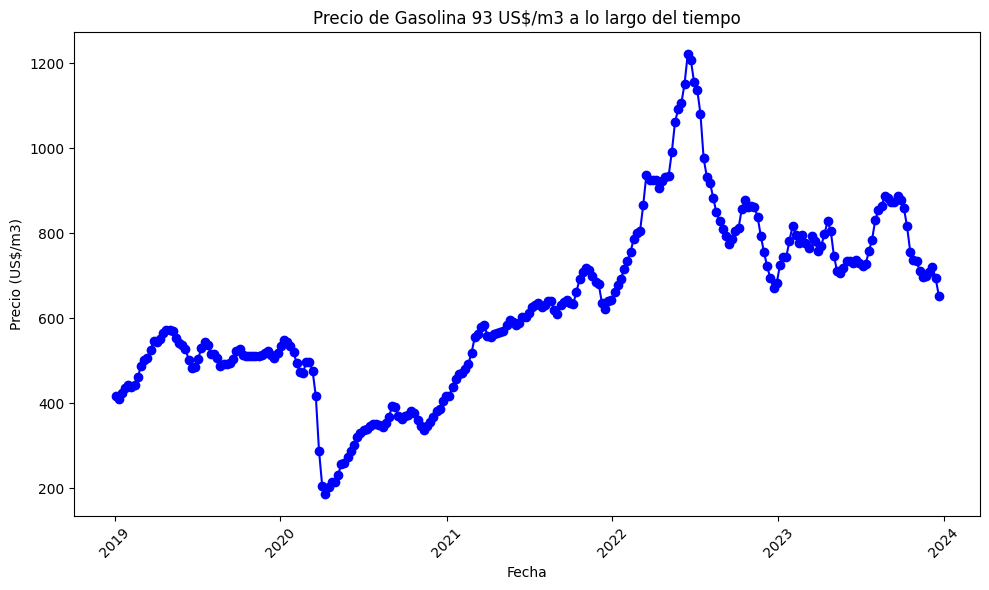

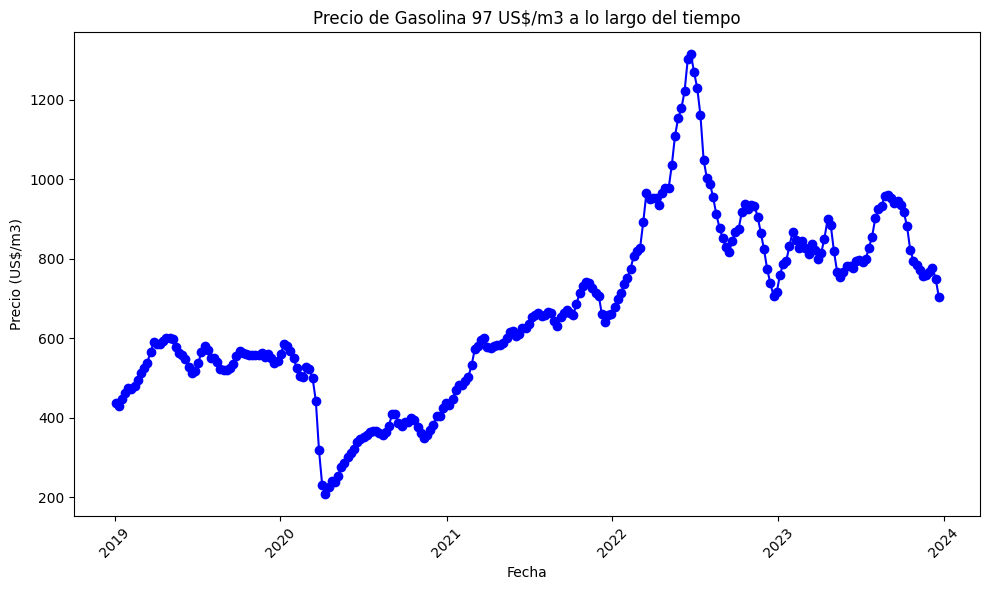

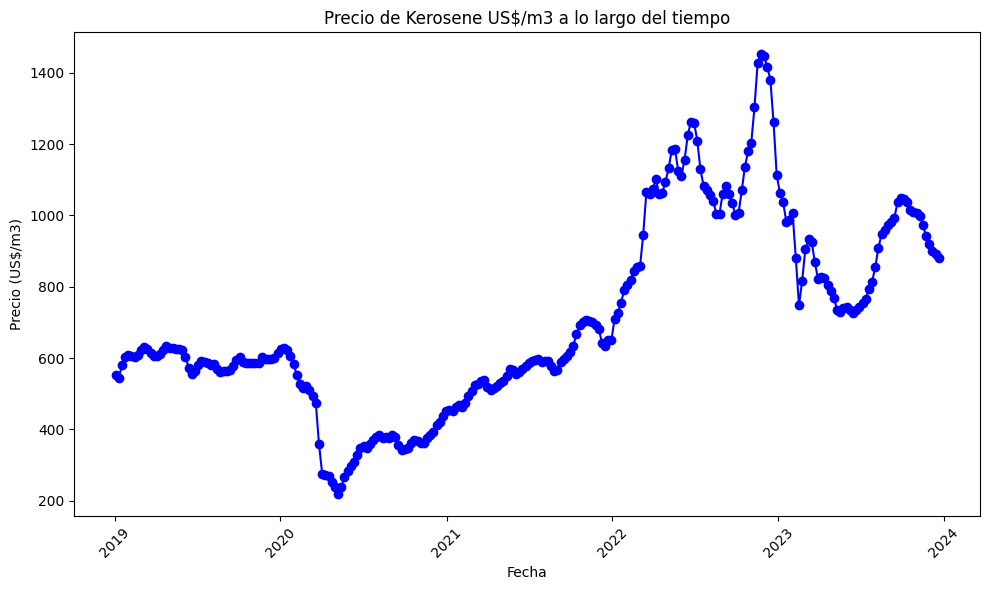

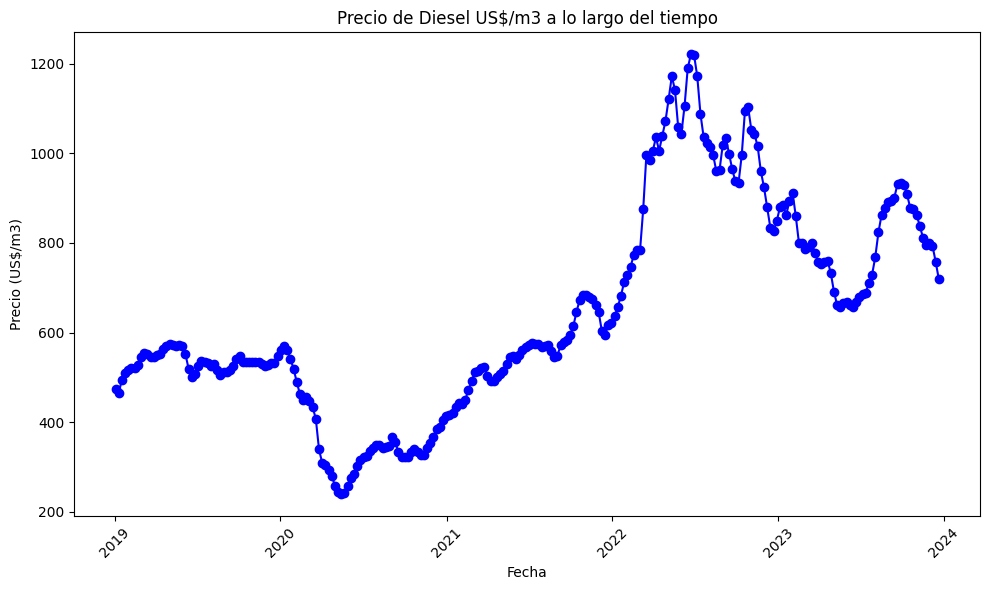

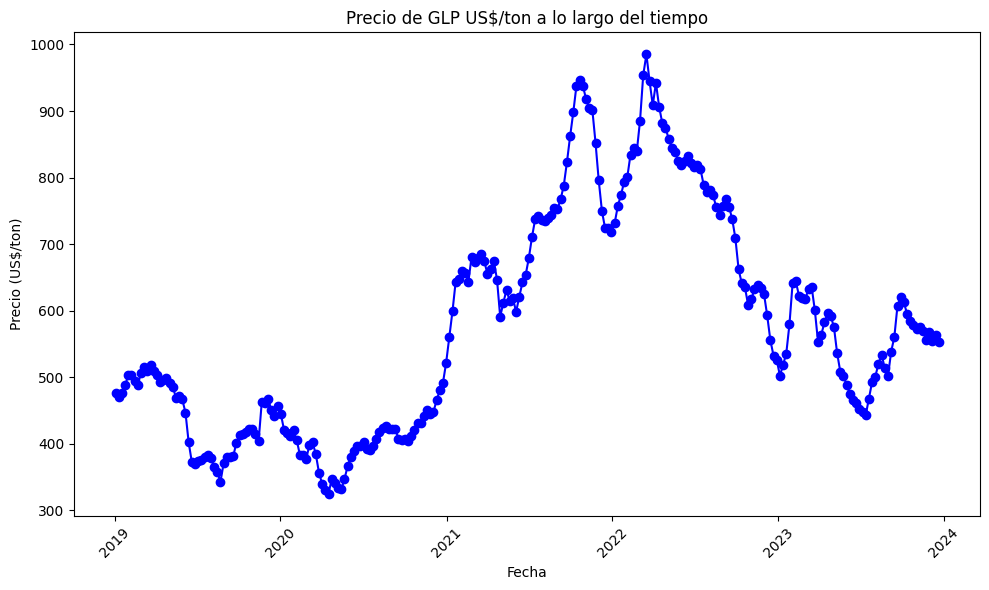

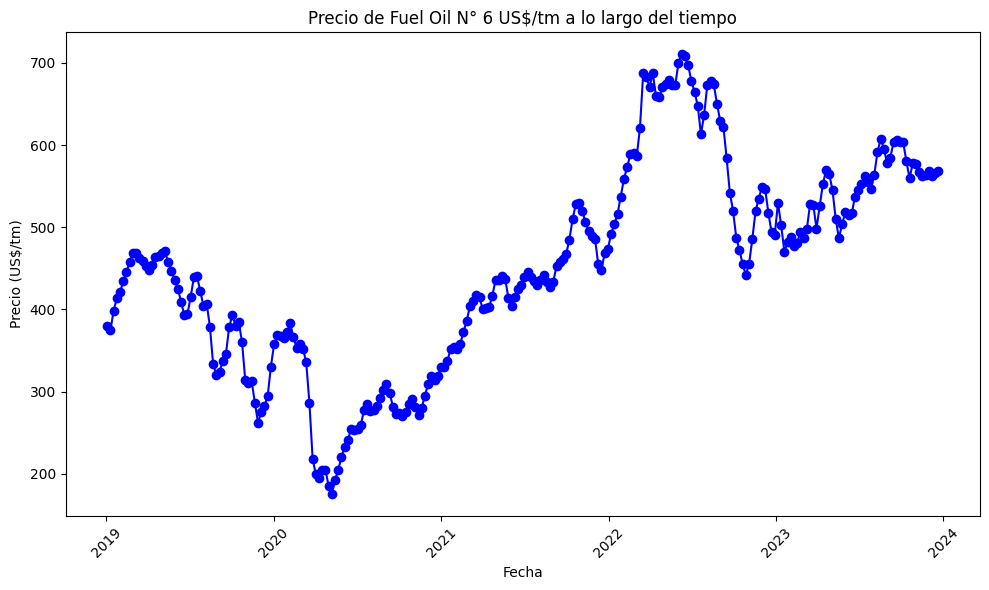

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def cargar_datos_desde_web(url):
    # Use pandas.read_html() to read tables from the webpage
    tables = pd.read_html(url)
    df = tables[0]
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    df = df.rename(columns={'Unnamed: 0_level_0 Fecha': 'Fecha'})
    return df

def modificar_valores_fecha(df, valores_a_buscar):
    for valor_a_buscar, nuevo_valor in valores_a_buscar:
        df['Fecha'] = df['Fecha'].replace(valor_a_buscar, nuevo_valor, regex=True)

def procesar_fechas(df):
    df['Fecha'] = df['Fecha'].str.replace('sept', 'sep', case=False)

    spanish_month_names = {'ene': '01', 'feb': '02', 'mar': '03', 'abr': '04', 'may': '05', 'jun': '06',
                           'jul': '07', 'ago': '08', 'sep': '09', 'oct': '10', 'nov': '11', 'dic': '12'}

    df['day'] = df['Fecha'].str.extract(r'(\d+)')
    df['month'] = df['Fecha'].str.extract(r'([a-z]+)')
    df['year'] = df['Fecha'].str.extract(r'(\d+)$')
    df['month'] = df['month'].map(spanish_month_names)
    df['Fecha'] = pd.to_datetime(df['day'] + '-' + df['month'] + '-' + df['year'], format='%d-%m-%y')
    df = df.drop(['day', 'month', 'year'], axis=1)
    df = df.sort_values(by='Fecha')
    df['Fecha'] = pd.to_datetime(df['Fecha'])

    return df

def dividir_columnas_numericas(df):
    numeric_columns = df.columns.difference(['Fecha'])
    df[numeric_columns] = df[numeric_columns].div(100)
    return df

def generar_graficos(df):
    for columna in df.columns[1:]:
        plt.figure(figsize=(10, 6))
        plt.plot(df['Fecha'], df[columna], marker='o', linestyle='-', color='b')
        plt.title(f'Precio de {columna} a lo largo del tiempo')
        plt.xlabel('Fecha')
        plt.ylabel(f'Precio ({columna.split()[-1]})')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

def interpolar_ceros(df, columna):
    zero_rows = df[df[columna] < 100]

    for index, row in zero_rows.iterrows():
        if index - 1 >= 0 and index + 1 < len(df):
            new_value = (df.at[index - 1, columna] + df.at[index + 1, columna]) / 2
            df.at[index, columna] = new_value

# Especificar el URL de la página web
url = 'https://www.enap.cl/pag/66/1295/tabla_de_precios_de_paridad'

# Cargar datos desde la web
df = cargar_datos_desde_web(url)

# Modificar valores en la columna 'Fecha'
valores_a_buscar = [
    ("08-jun23", "08-jun-23"),
    ("09-feb.23", "09-feb-23"),
    ("28.may-20", "28-may-20")
]
modificar_valores_fecha(df, valores_a_buscar)

# Procesar las fechas en el DataFrame
df = procesar_fechas(df)

# Dividir las columnas numéricas por 100
df = dividir_columnas_numericas(df)

# Filtrar solo los datos desde 2019
df = df[df['Fecha'].dt.year >= 2019]

# Encuentra y reemplaza ceros en la columna 'Diesel US$/m3'
interpolar_ceros(df, 'Diesel US$/m3')

# Encuentra y reemplaza ceros en la columna 'Gasolina 93 US$/m3'
interpolar_ceros(df, 'Gasolina 93 US$/m3')

# Generar gráficos
generar_graficos(df)

# Obtener USD/CLP  

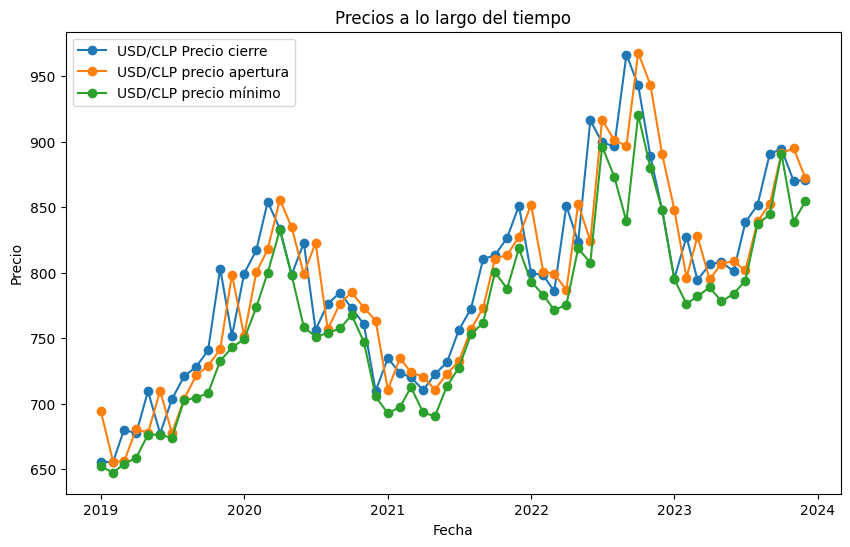

In [2]:
def cargar_datos_desde_csv(file_path, columns):
    try:
        clp = pd.read_csv(file_path, parse_dates=['Fecha'], dayfirst=True)[columns]
    except FileNotFoundError:
        print(f"Error: El archivo '{file_path}' no fue encontrado.")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: El archivo '{file_path}' está vacío.")
        return None
    return clp

def procesar_datos(clp, numeric_columns):
    for col in numeric_columns:
        clp[col] = clp[col].replace({',': '', r'\.\d+': ''}, regex=True)

    clp[numeric_columns] = clp[numeric_columns].astype(int)
    clp[numeric_columns] = clp[numeric_columns].div(100)

    clp.columns = ['Fecha', 'USD/CLP Precio cierre', 'USD/CLP precio apertura', 'USD/CLP precio mínimo']

    clp['Fecha'] = pd.to_datetime(clp['Fecha'], format='%d.%m.%Y')

    # Filtrar solo los datos desde 2019
    clp = clp[clp['Fecha'].dt.year >= 2019]

    return clp

def trazar_series_temporales(df, columns_to_plot):
    plt.figure(figsize=(10, 6))
    for col in columns_to_plot:
        plt.plot(df['Fecha'], df[col], label=col, marker='o')

    plt.title('Precios a lo largo del tiempo')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.legend()
    plt.show()

# Uso en el notebook
file_path = "clp2.csv"
columns_to_select = ['Fecha', 'Último', 'Apertura', 'Mínimo']
numeric_columns = ['Último', 'Apertura', 'Mínimo']
columns_to_plot = ['USD/CLP Precio cierre', 'USD/CLP precio apertura', 'USD/CLP precio mínimo']

clp = cargar_datos_desde_csv(file_path, columns_to_select)

if clp is not None:
    clp = procesar_datos(clp, numeric_columns)
    trazar_series_temporales(clp, columns_to_plot)


# Obtener [IPC](https://www.ine.gob.cl/estadisticas/economia/indices-de-precio-e-inflacion/indice-de-precios-al-consumidor) 

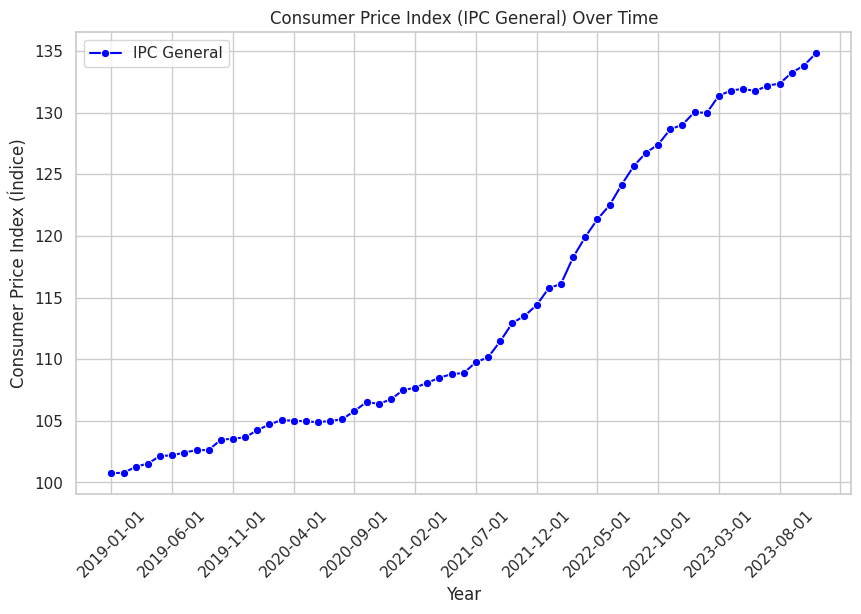

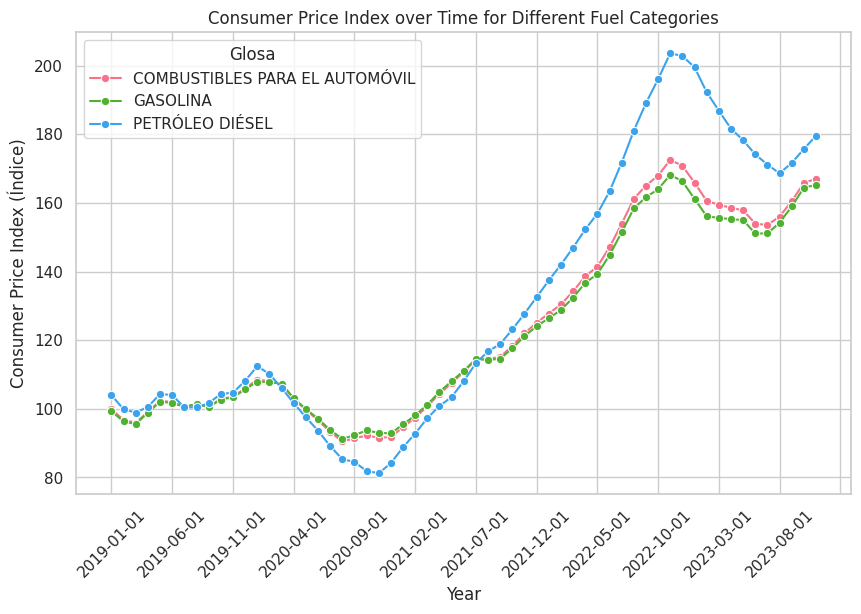

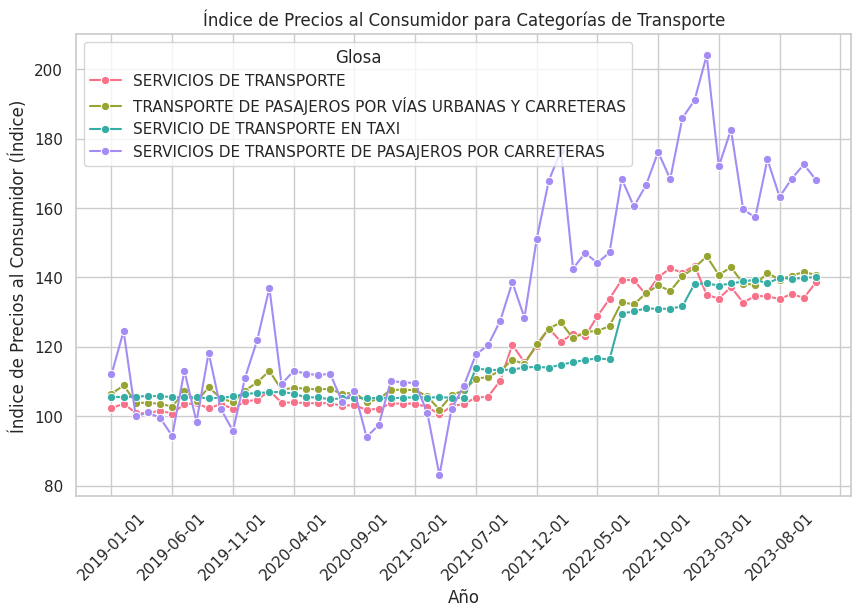

In [3]:
def cargar_datos_ipc(file_path):
    """
    Carga datos desde un archivo Excel y devuelve el DataFrame.
    """
    try:
        ipc = pd.read_excel(file_path, skiprows=3)
        return ipc
    except FileNotFoundError:
        print(f"Error: El archivo {file_path} no fue encontrado.")
        return None
    except Exception as e:
        print(f"Error al cargar datos: {e}")
        return None

def procesar_datos_ipc(ipc):
    """
    Procesa el DataFrame IPC y devuelve el DataFrame procesado.
    """
    ipc['Año'] = ipc['Año'].astype(str)
    ipc['Mes'] = ipc['Mes'].astype(str)
    
    ipc['Fecha'] = ipc.apply(lambda row: f"01-{row['Mes']}-{row['Año']}", axis=1)
    ipc['Fecha'] = pd.to_datetime(ipc['Fecha'], format='%d-%m-%Y')
    
    ipc = ipc.drop(['Año', 'Mes'], axis=1)
    
    ipc['Fecha'] = ipc['Fecha'].dt.strftime('%Y-%m-%d')
    ipc = ipc[['Glosa', 'Índice', 'Fecha']]
    ipc.columns = ['Glosa', 'IPC General', 'Fecha']
    
    return ipc

def trazar_ipc_general(ipc_general):
    """
    Trazar el IPC General a lo largo del tiempo.
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Fecha', y='IPC General', data=ipc_general, marker='o', color='blue', label='IPC General')
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5))
    plt.title('Consumer Price Index (IPC General) Over Time')
    plt.xlabel('Year')
    plt.ylabel('Consumer Price Index (Índice)')
    plt.show()

def trazar_ipc_combustible(ipc_combustible):
    """
    Trazar el IPC para categorías de combustibles a lo largo del tiempo.
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Fecha', y='IPC General', hue='Glosa', data=ipc_combustible, marker='o', palette='husl')
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5))
    plt.title('Consumer Price Index over Time for Different Fuel Categories')
    plt.xlabel('Year')
    plt.ylabel('Consumer Price Index (Índice)')
    plt.show()

def trazar_ipc_categoria_transportes(ipc_categoria):
    """
    Trazar el IPC para la categoría de transporte a lo largo del tiempo.
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    plot = sns.lineplot(x='Fecha', y='IPC General', hue='Glosa', data=ipc_categoria, marker='o', palette='husl')
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5))
    plt.title('Índice de Precios al Consumidor para Categorías de Transporte')
    plt.xlabel('Año')
    plt.ylabel('Índice de Precios al Consumidor (Índice)')
    plt.show()

# Uso en el notebook
file_path_ipc = 'ipc.xlsx'
ipc = cargar_datos_ipc(file_path_ipc)

if ipc is not None:
    ipc = procesar_datos_ipc(ipc)

    # Filtrar y trazar IPC General
    ipc_general = ipc[ipc['Glosa'].eq('IPC General')][['Fecha', 'IPC General']]
    trazar_ipc_general(ipc_general)

    # Filtrar y trazar IPC para categorías de combustibles
    fuel_categories = ['COMBUSTIBLES PARA EL AUTOMÓVIL', 'GASOLINA', 'PETRÓLEO DIÉSEL']
    ipc_combustible = ipc[ipc['Glosa'].isin(fuel_categories)][['Fecha', 'Glosa', 'IPC General']]
    trazar_ipc_combustible(ipc_combustible)

    # Filtrar y Trazar IPC para categorías de transporte
    transportation_categories = [
        'SERVICIOS DE TRANSPORTE',
        'TRANSPORTE DE PASAJEROS POR VÍAS URBANAS Y CARRETERAS',
        'SERVICIO DE TRANSPORTE EN TAXI', 
        'SERVICIOS DE TRANSPORTE DE PASAJEROS POR CARRETERAS',
    ]
    ipc_transportation = ipc[ipc['Glosa'].isin(transportation_categories)][['Fecha', 'Glosa', 'IPC General']]
    trazar_ipc_categoria_transportes(ipc_transportation)

In [4]:
# Pivotear los DataFrames
ipc_combustible = ipc_combustible.pivot(index='Fecha', columns='Glosa', values='IPC General').reset_index()
ipc_transportation = ipc_transportation.pivot(index='Fecha', columns='Glosa', values='IPC General').reset_index()

# Asegúrate de tener las columnas 'Fecha' en formato datetime
ipc_combustible['Fecha'] = pd.to_datetime(ipc_combustible['Fecha'])
ipc_transportation['Fecha'] = pd.to_datetime(ipc_transportation['Fecha'])
ipc_general['Fecha'] = pd.to_datetime(ipc_general['Fecha'])

# Renombrar columnas para mayor claridad
ipc_combustible.columns = ['Fecha', 'IPC Combustibles para el automóvil', 'IPC Gasolina', 'IPC Petróleo Diesel']
ipc_transportation.columns = [
    'Fecha',
    'IPC Servicio de transporte en taxi',
    'IPC Servicios de transporte',  
    'IPC Servicios de transporte de pasajeros por vías urbanas',
    'IPC Transporte de pasajeros por vías urbanas y carreteras' 
]

# Realizar el merge de los DataFrames
ipcs = pd.merge(ipc_combustible, ipc_transportation, on='Fecha', how='outer')
ipcs = pd.merge(ipcs, ipc_general, on='Fecha', how='outer')

# Ordenar el DataFrame por la columna 'Fecha'
ipcs = ipcs.sort_values('Fecha')

# Mostrar el DataFrame resultante
ipcs

Fecha  IPC Combustibles para el automóvil  IPC Gasolina  \
0  2019-01-01                               99.83         99.25   
1  2019-02-01                               96.76         96.32   
2  2019-03-01                               95.95         95.54   
3  2019-04-01                               99.09         98.88   
4  2019-05-01                              102.33        102.06   
5  2019-06-01                              101.98        101.70   
6  2019-07-01                              100.56        100.58   
7  2019-08-01                              101.26        101.38   
8  2019-09-01                              100.64        100.51   
9  2019-10-01                              102.90        102.70   
10 2019-11-01                              103.50        103.33   
11 2019-12-01                              105.95        105.65   
12 2020-01-01                              108.50        107.95   
13 2020-02-01                              108.04        107.74   
14 2020-03-01                              107.18        107.34   
15 2020-04-01                              102.91        103.09   
16 2020-05-01                               99.65         99.95   
17 2020-06-01                               96.69         97.12   
18 2020-07-01                               93.25         93.83   
19 2020-08-01                               90.52         91.25   
20 2020-09-01                               91.36         92.32   
21 2020-10-01                               92.24         93.69   
22 2020-11-01                               91.56         93.02   
23 2020-12-01                               91.75         92.82   
24 2021-01-01                               94.64         95.46   
25 2021-02-01                               97.43         98.08   
26 2021-03-01                              100.71        101.20   
27 2021-04-01                              104.42        104.93   
28 2021-05-01                              107.46        108.02   
29 2021-06-01                              110.71        111.08   
30 2021-07-01                              114.35        114.50   
31 2021-08-01                              114.53        114.22   
32 2021-09-01                              115.12        114.59   
33 2021-10-01                              118.31        117.63   
34 2021-11-01                              121.98        121.18   
35 2021-12-01                              125.10        124.05   
36 2022-01-01                              127.77        126.41   
37 2022-02-01                              130.43        128.80   
38 2022-03-01                              134.19        132.39   
39 2022-04-01                              138.63        136.71   
40 2022-05-01                              141.44        139.27   
41 2022-06-01                              147.06        144.77   
42 2022-07-01                              153.94        151.44   
43 2022-08-01                              161.19        158.40   
44 2022-09-01                              165.06        161.68   
45 2022-10-01                              167.95        163.99   
46 2022-11-01                              172.56        168.18   
47 2022-12-01                              170.81        166.30   
48 2023-01-01                              165.89        161.16   
49 2023-02-01                              160.57        156.11   
50 2023-03-01                              159.48        155.63   
51 2023-04-01                              158.54        155.29   
52 2023-05-01                              157.85        154.97   
53 2023-06-01                              153.94        151.09   
54 2023-07-01                              153.57        151.10   
55 2023-08-01                              156.02        154.24   
56 2023-09-01                              160.53        158.96   
57 2023-10-01                              165.82        164.43   
58 2023-11-01                              167.02      

## Correlaciones entre diferentes tipos de combustibles y el índice IPC general:

### - Gasolina 93 US/m3 con IPC general
### - Diesel US/m3 con IPC general

In [5]:
# Realizar interpolación en cada DataFrame
ipcs = ipcs.interpolate()
df = df.interpolate()
clp = clp.interpolate()

# Hacer merge de los tres DataFrames
merged_df = pd.merge(ipcs, df, on='Fecha', how='outer')
merged_df = pd.merge(merged_df, clp, on='Fecha', how='outer')

# Ordenar el DataFrame resultante por la columna 'Fecha'
merged_df = merged_df.sort_values('Fecha')

In [6]:
merged_df = merged_df.interpolate()
merged_df = merged_df.dropna()
merged_df

Fecha  IPC Combustibles para el automóvil  IPC Gasolina  \
59  2019-01-03                           99.318333     98.761667   
60  2019-01-10                           98.806667     98.273333   
61  2019-01-17                           98.295000     97.785000   
62  2019-01-24                           97.783333     97.296667   
63  2019-01-31                           97.271667     96.808333   
..         ...                                 ...           ...   
308 2023-11-30                          167.020000    165.260000   
312 2023-12-01                          167.020000    165.260000   
309 2023-12-07                          167.020000    165.260000   
310 2023-12-14                          167.020000    165.260000   
311 2023-12-21                          167.020000    165.260000   

     IPC Petróleo Diesel  IPC Servicio de transporte en taxi  \
59            103.261667                              105.57   
60            102.583333                              105.57   
61            101.905000                              105.57   
62            101.226667                              105.57   
63            100.548333                              105.57   
..                   ...                                 ...   
308           179.570000                              140.12   
312           179.570000                              140.12   
309           179.570000                              140.12   
310           179.570000                              140.12   
311           179.570000                              140.12   

     IPC Servicios de transporte  \
59                    102.538333   
60                    102.766667   
61                    102.995000   
62                    103.223333   
63                    103.451667   
..                           ...   
308                   138.660000   
312                   138.660000   
309                   138.660000   
310                   138.660000   
311                   138.660000   

     IPC Servicios de transporte de pasajeros por vías urbanas  \
59                                          114.153333           
60                                          116.236667           
61                                          118.320000           
62                                          120.403333           
63                                          122.486667           
..                                                 ...           
308                                         168.060000           
312                                         168.060000           
309                                         168.060000           
310                                         168.060000           
311                                         168.060000           

     IPC Transporte de pasajeros por vías urbanas y carreteras  IPC General  \
59                                          106.878333           100.756667   
60                                          107.286667           100.763333   
61                                          107.695000           100.770000   
62                                          108.103333           100.776667   
63                                          108.511667           100.783333   
..                                                 ...                  ...   
308                                         140.740000           134.820000   
312                                         140.740000           134.820000   
309                                         140.740000           134.820000   
310                                         140.740000           134.820000   
311                                         140.740000           134.820000   

     Gasolina 93 US$/m3  Gasolina 97 US$/m3  Kerosene US$/m3  Diesel US$/m3  \
59               416.55             437.120           552.80        473.100   
60               410.50             431.000           544.21        466.280   
61         

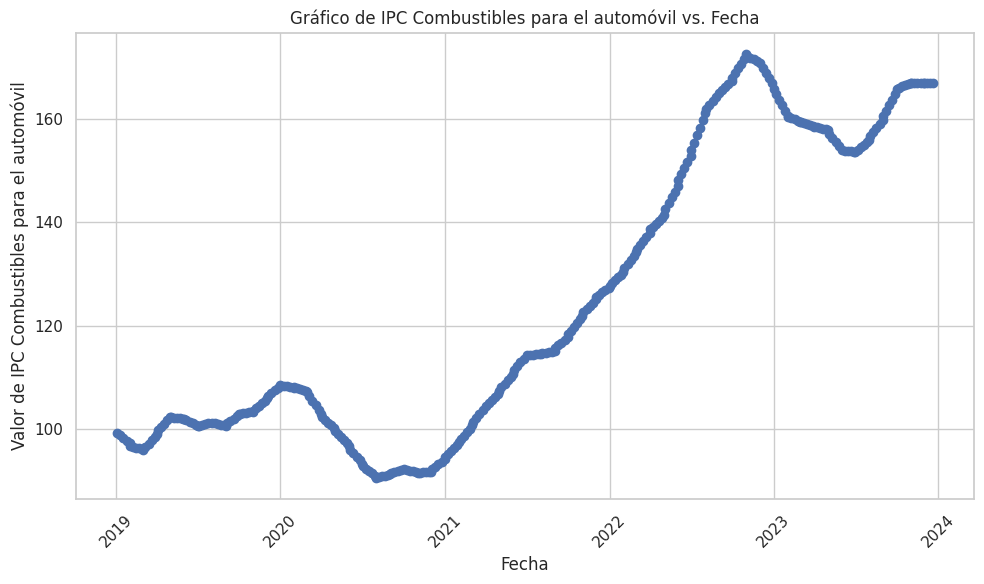

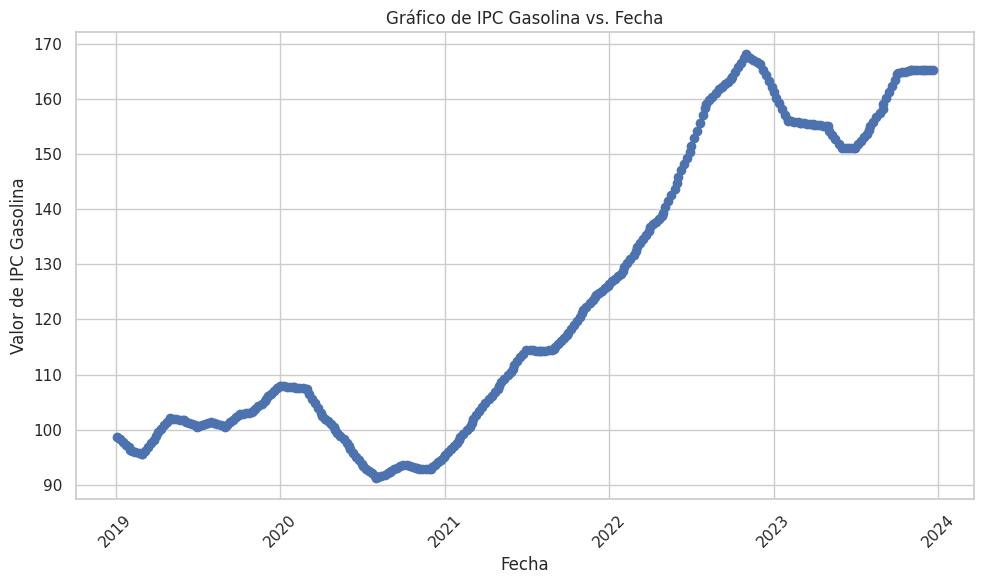

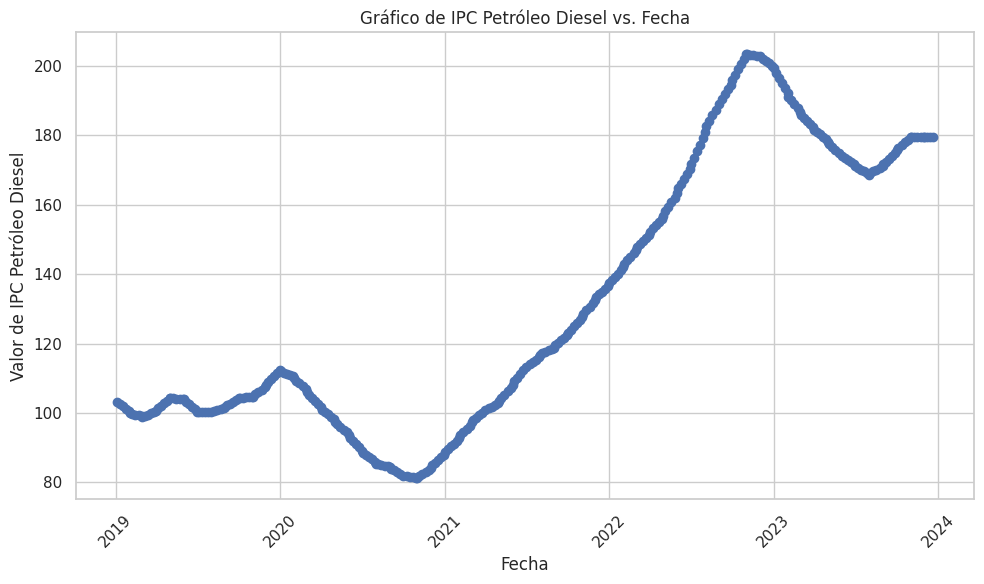

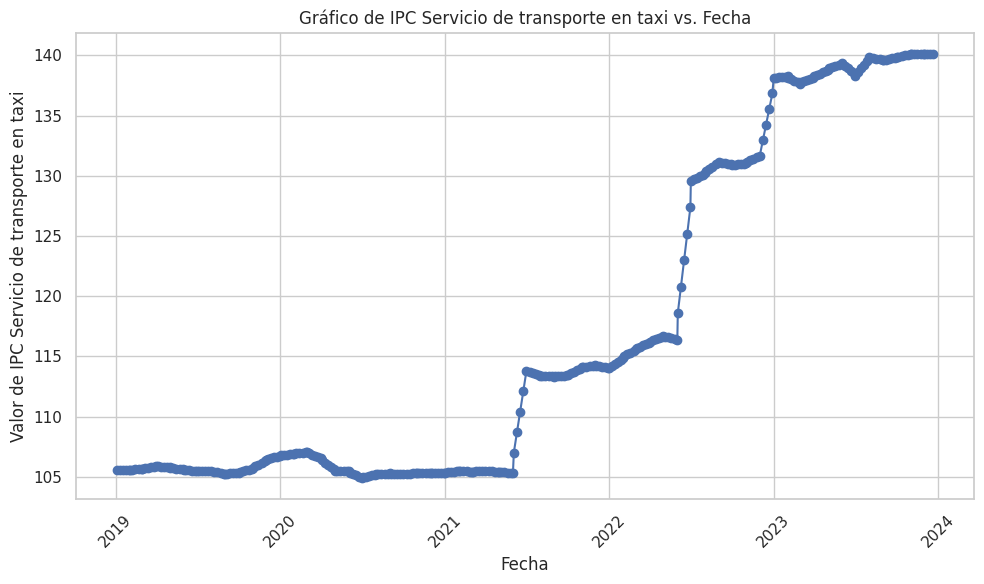

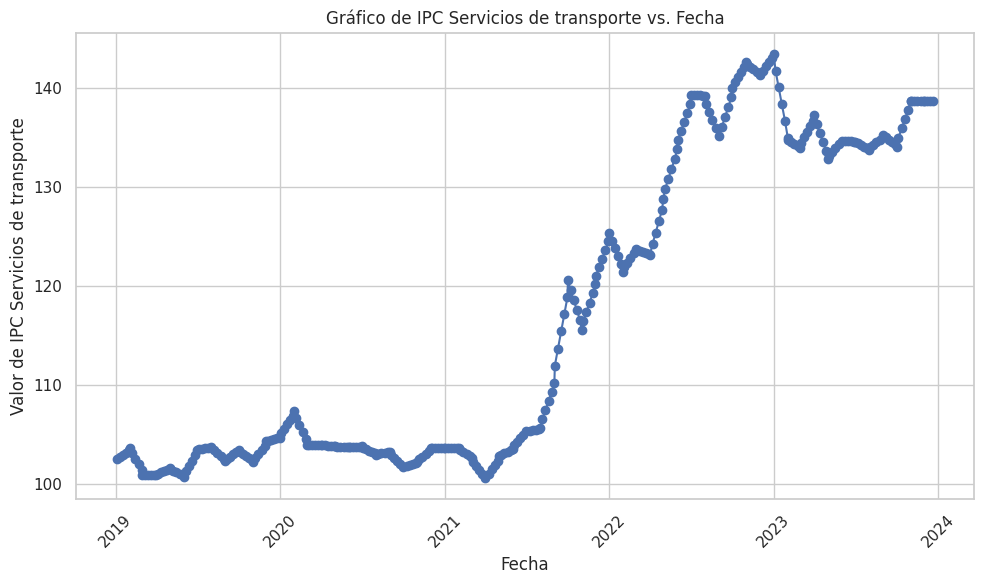

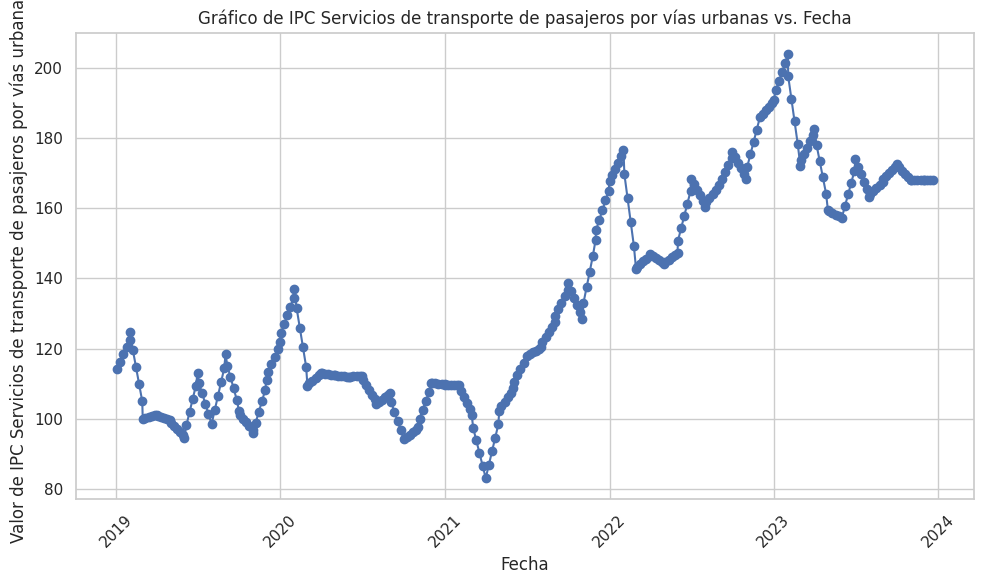

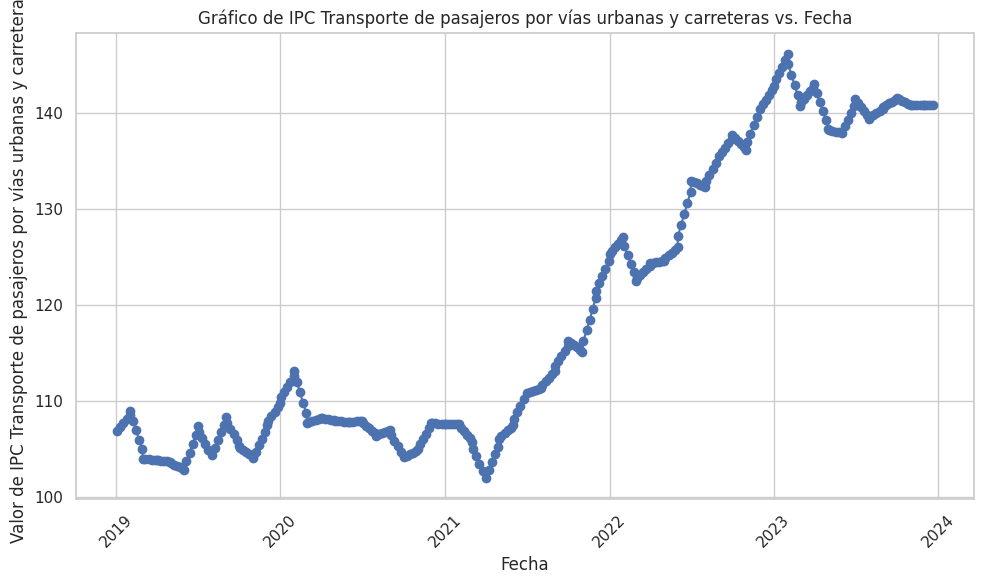

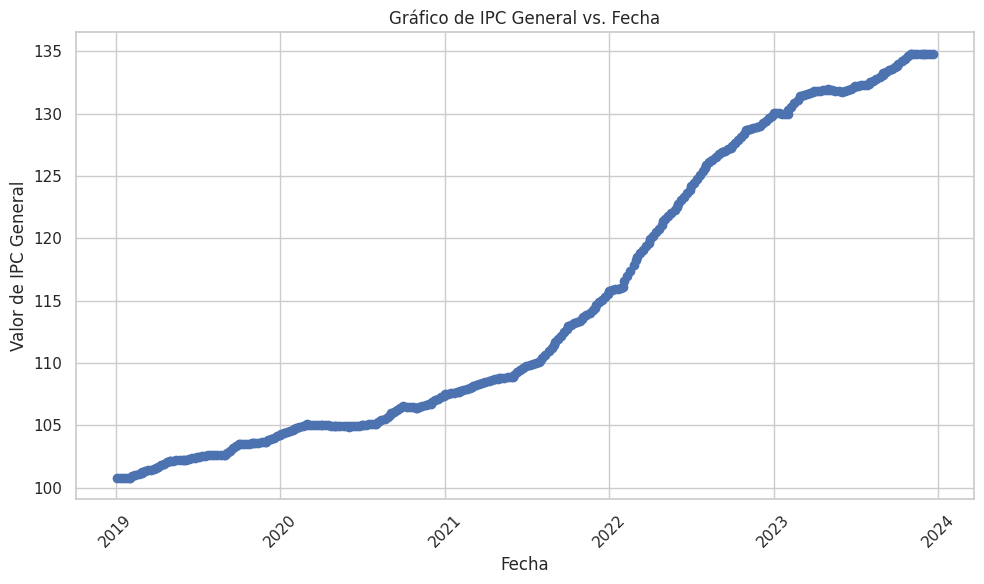

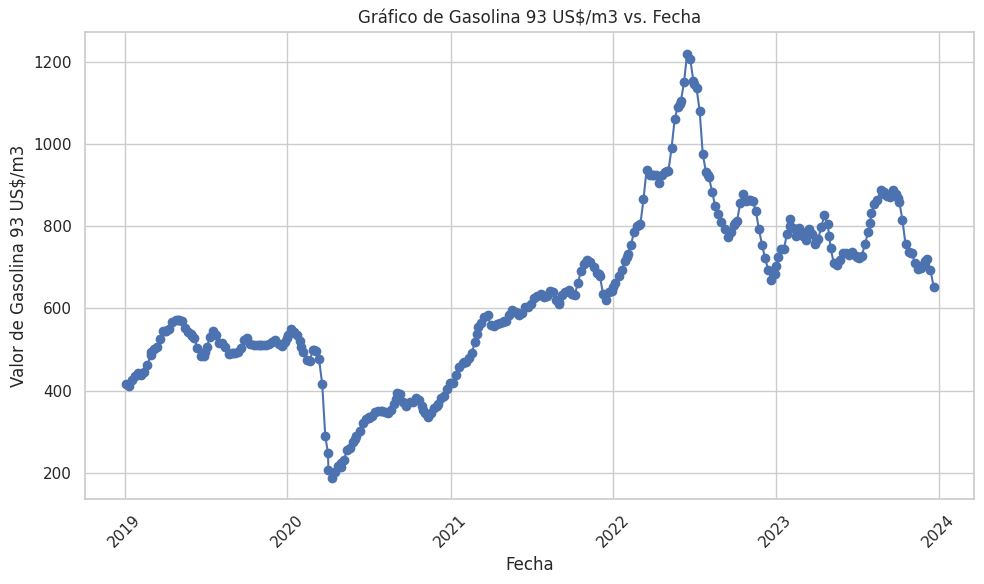

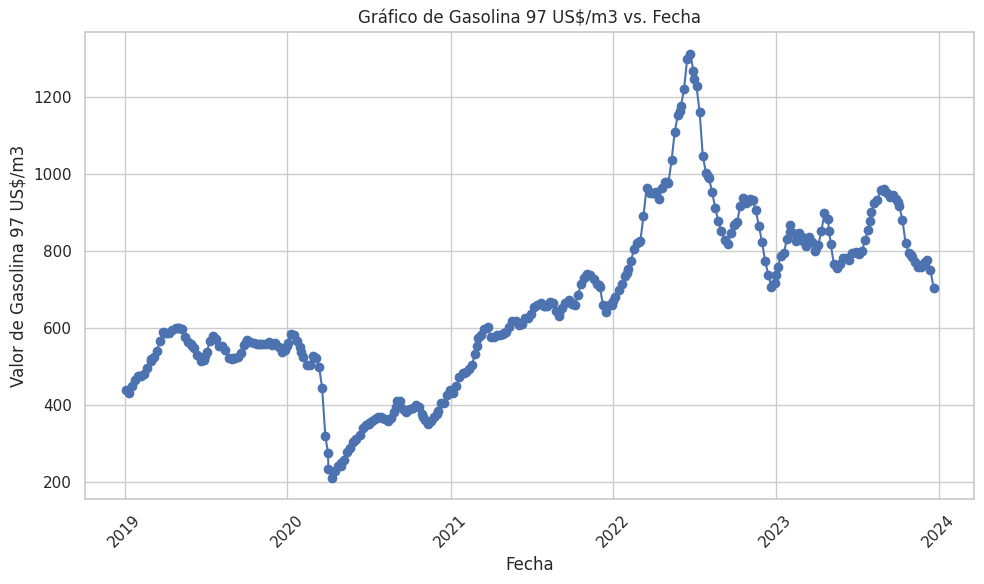

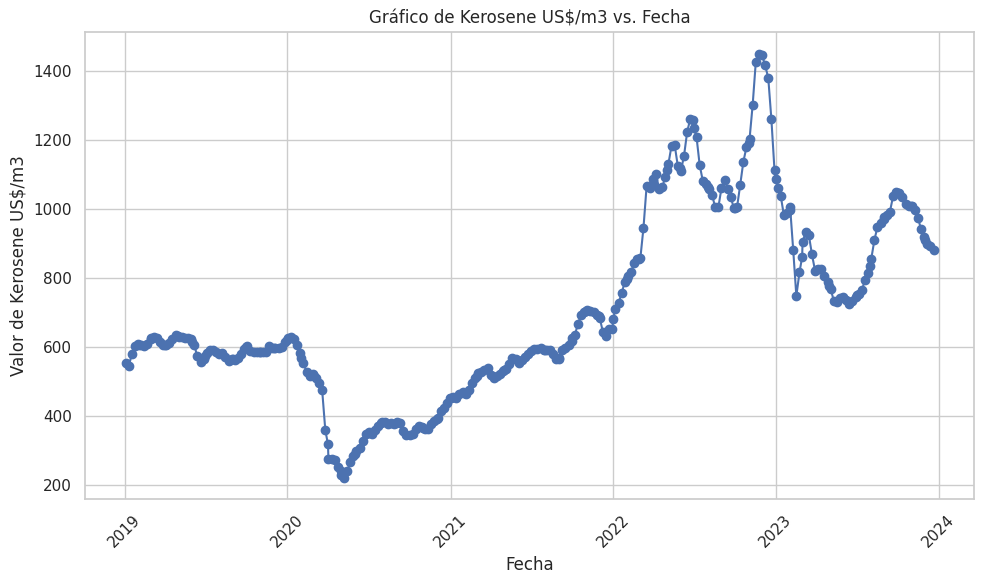

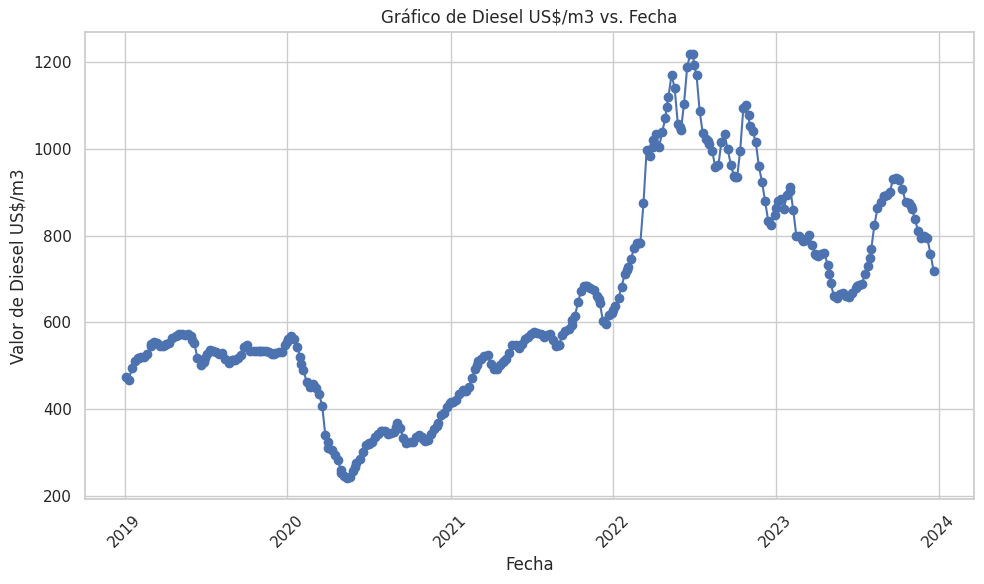

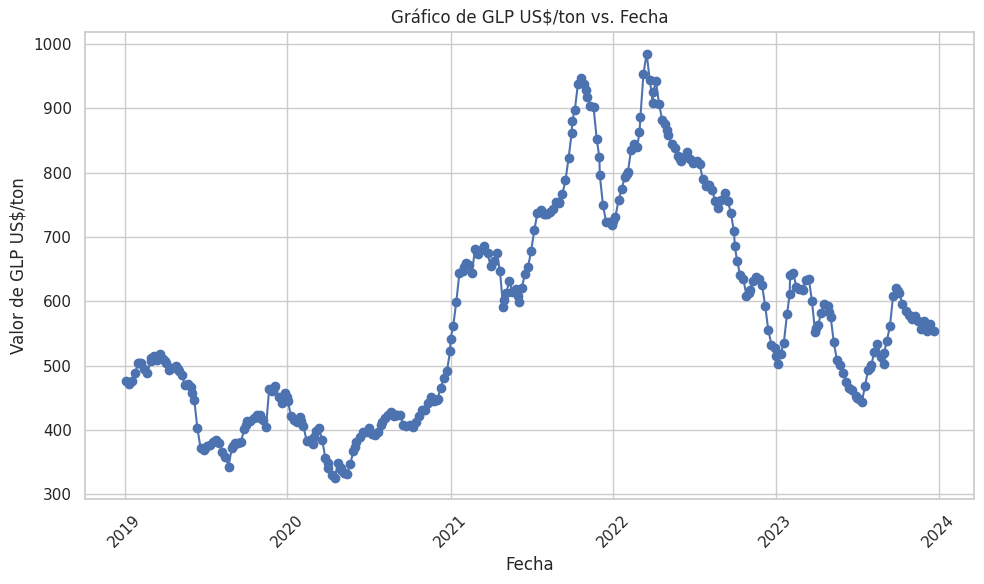

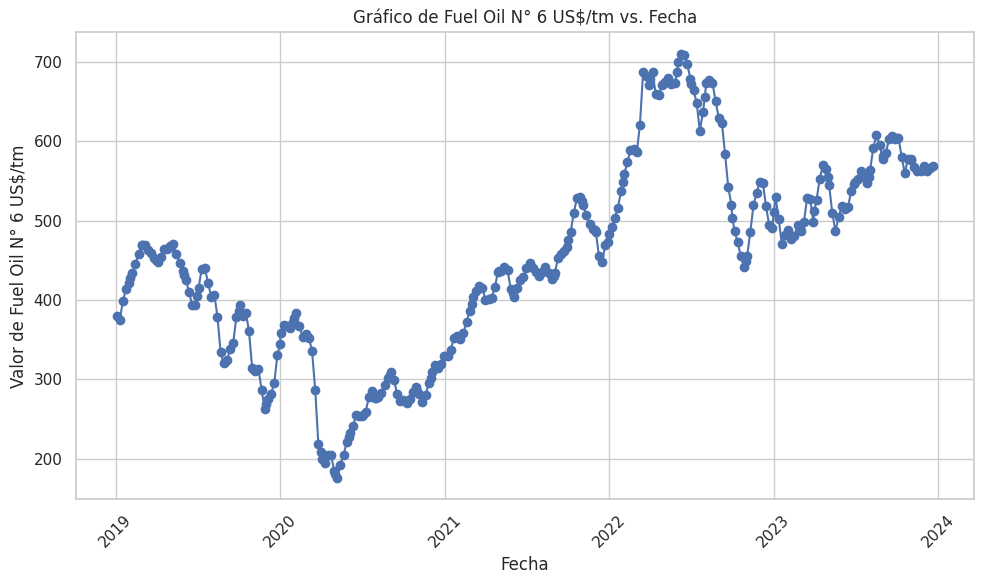

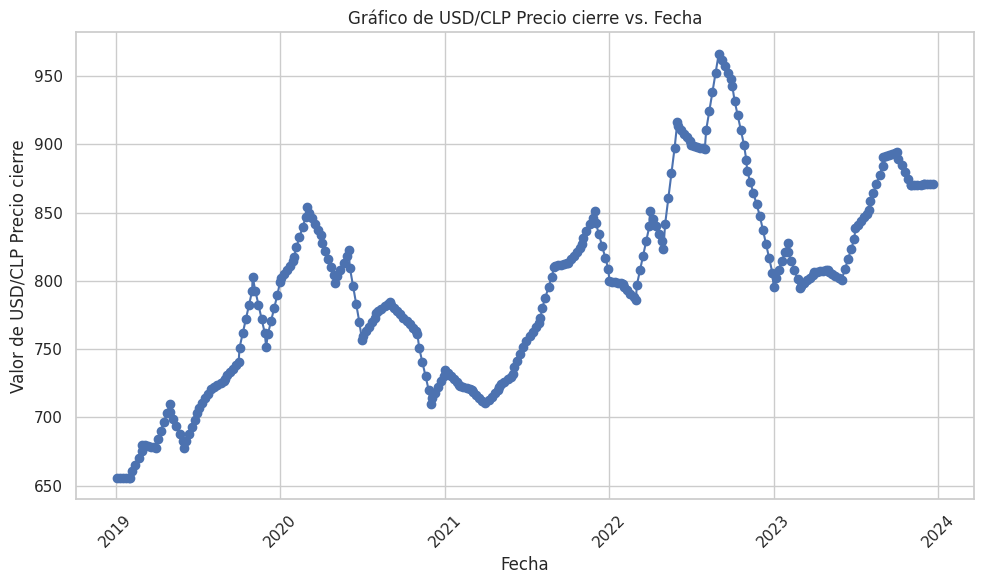

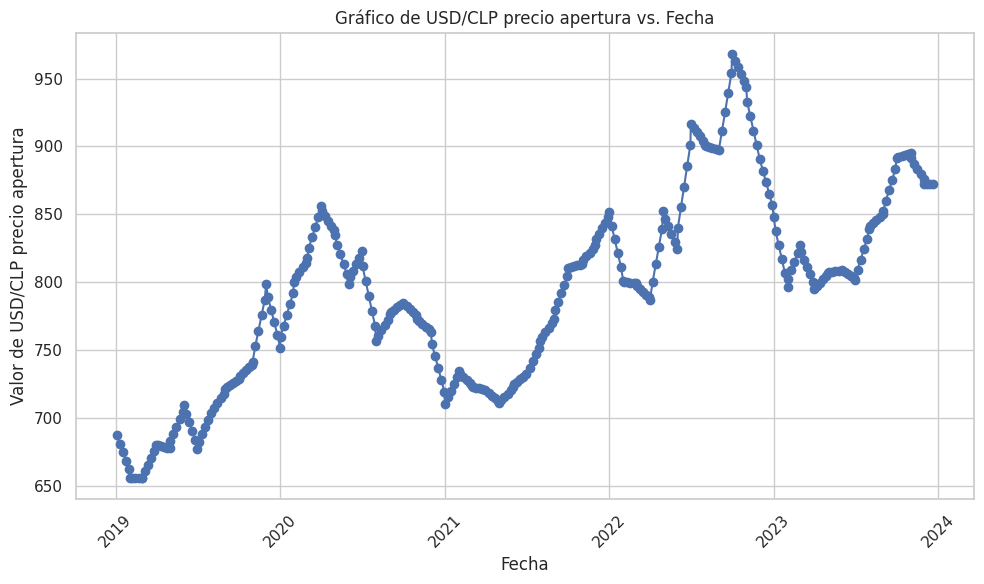

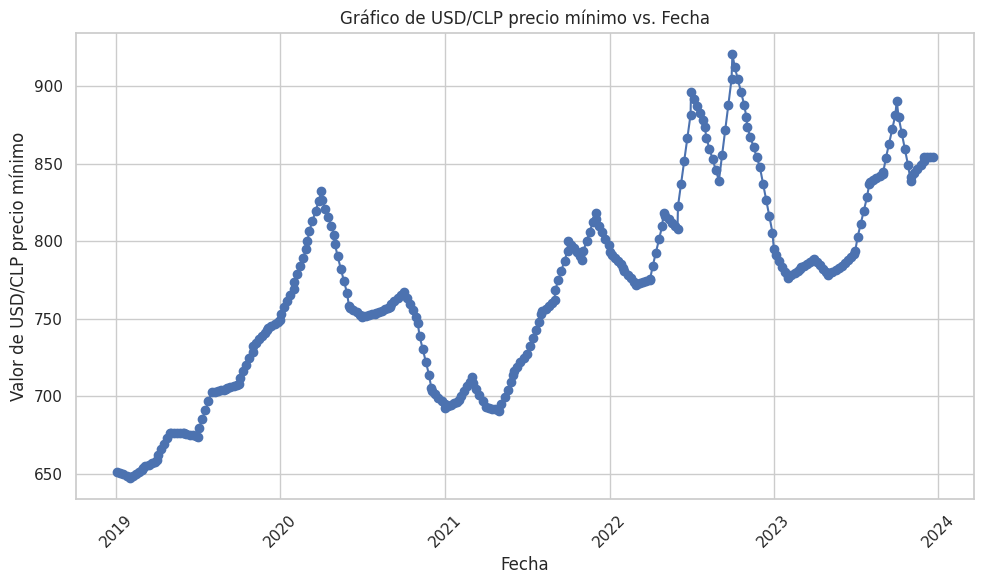

In [7]:
# Iterar sobre todas las columnas de merged_df (excluyendo la columna 'Fecha')
for columna in merged_df.columns[1:]:
    # Configurar el tamaño del gráfico
    plt.figure(figsize=(10, 6))
    
    # Crear el gráfico de columna vs. Fecha para la columna actual
    plt.plot(merged_df['Fecha'], merged_df[columna], marker='o')
    
    # Configurar etiquetas y título
    plt.title(f'Gráfico de {columna} vs. Fecha')
    plt.xlabel('Fecha')
    plt.ylabel(f'Valor de {columna}')
    plt.xticks(rotation=45)
    
    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

In [8]:
merged_df.columns

Index(['Fecha', 'IPC Combustibles para el automóvil', 'IPC Gasolina',
       'IPC Petróleo Diesel', 'IPC Servicio de transporte en taxi',
       'IPC Servicios de transporte',
       'IPC Servicios de transporte de pasajeros por vías urbanas',
       'IPC Transporte de pasajeros por vías urbanas y carreteras',
       'IPC General', 'Gasolina 93 US$/m3', 'Gasolina 97 US$/m3',
       'Kerosene US$/m3', 'Diesel US$/m3', 'GLP US$/ton',
       'Fuel Oil N° 6 US$/tm', 'USD/CLP Precio cierre',
       'USD/CLP precio apertura', 'USD/CLP precio mínimo'],
      dtype='object')

In [9]:
merged_df[['IPC Combustibles para el automóvil', 'IPC Petróleo Diesel', 'IPC Servicios de transporte',
       'IPC General', 'Gasolina 93 US$/m3', 'Gasolina 97 US$/m3',
      'Diesel US$/m3', 'USD/CLP Precio cierre']].describe()

IPC Combustibles para el automóvil  IPC Petróleo Diesel  \
count                          312.000000           312.000000   
mean                           124.398638           131.708125   
std                             27.857805            38.540494   
min                             90.520000            81.220000   
25%                            100.843000           100.564583   
50%                            113.986000           112.850000   
75%                            155.652500           171.907500   
max                            172.560000           203.620000   

       IPC Servicios de transporte  IPC General  Gasolina 93 US$/m3  \
count                   312.000000   312.000000          312.000000   
mean                    116.803958   114.786667          623.871234   
std                      15.412180    11.626394          204.802926   
min                     100.640000   100.756667          187.140000   
25%                     103.260500   104.942500          493.812500   
50%                     105.833000   109.672000          606.945000   
75%                     134.481250   127.179000          771.095000   
max                     143.410000   134.820000         1220.510000   

       Gasolina 97 US$/m3  Diesel US$/m3  USD/CLP Precio cierre  
count          312.000000     312.000000             312.000000  
mean           660.320208     641.682853             795.464407  
std            219.694182     232.865314              69.115805  
min            208.910000     240.180000             655.425000  
25%            521.785000     507.435000             735.407500  
50%            628.745000     569.010000             801.462000  
75%            820.632500     799.457500             840.086250  
max           1313.590000    1220.520000             966.630000

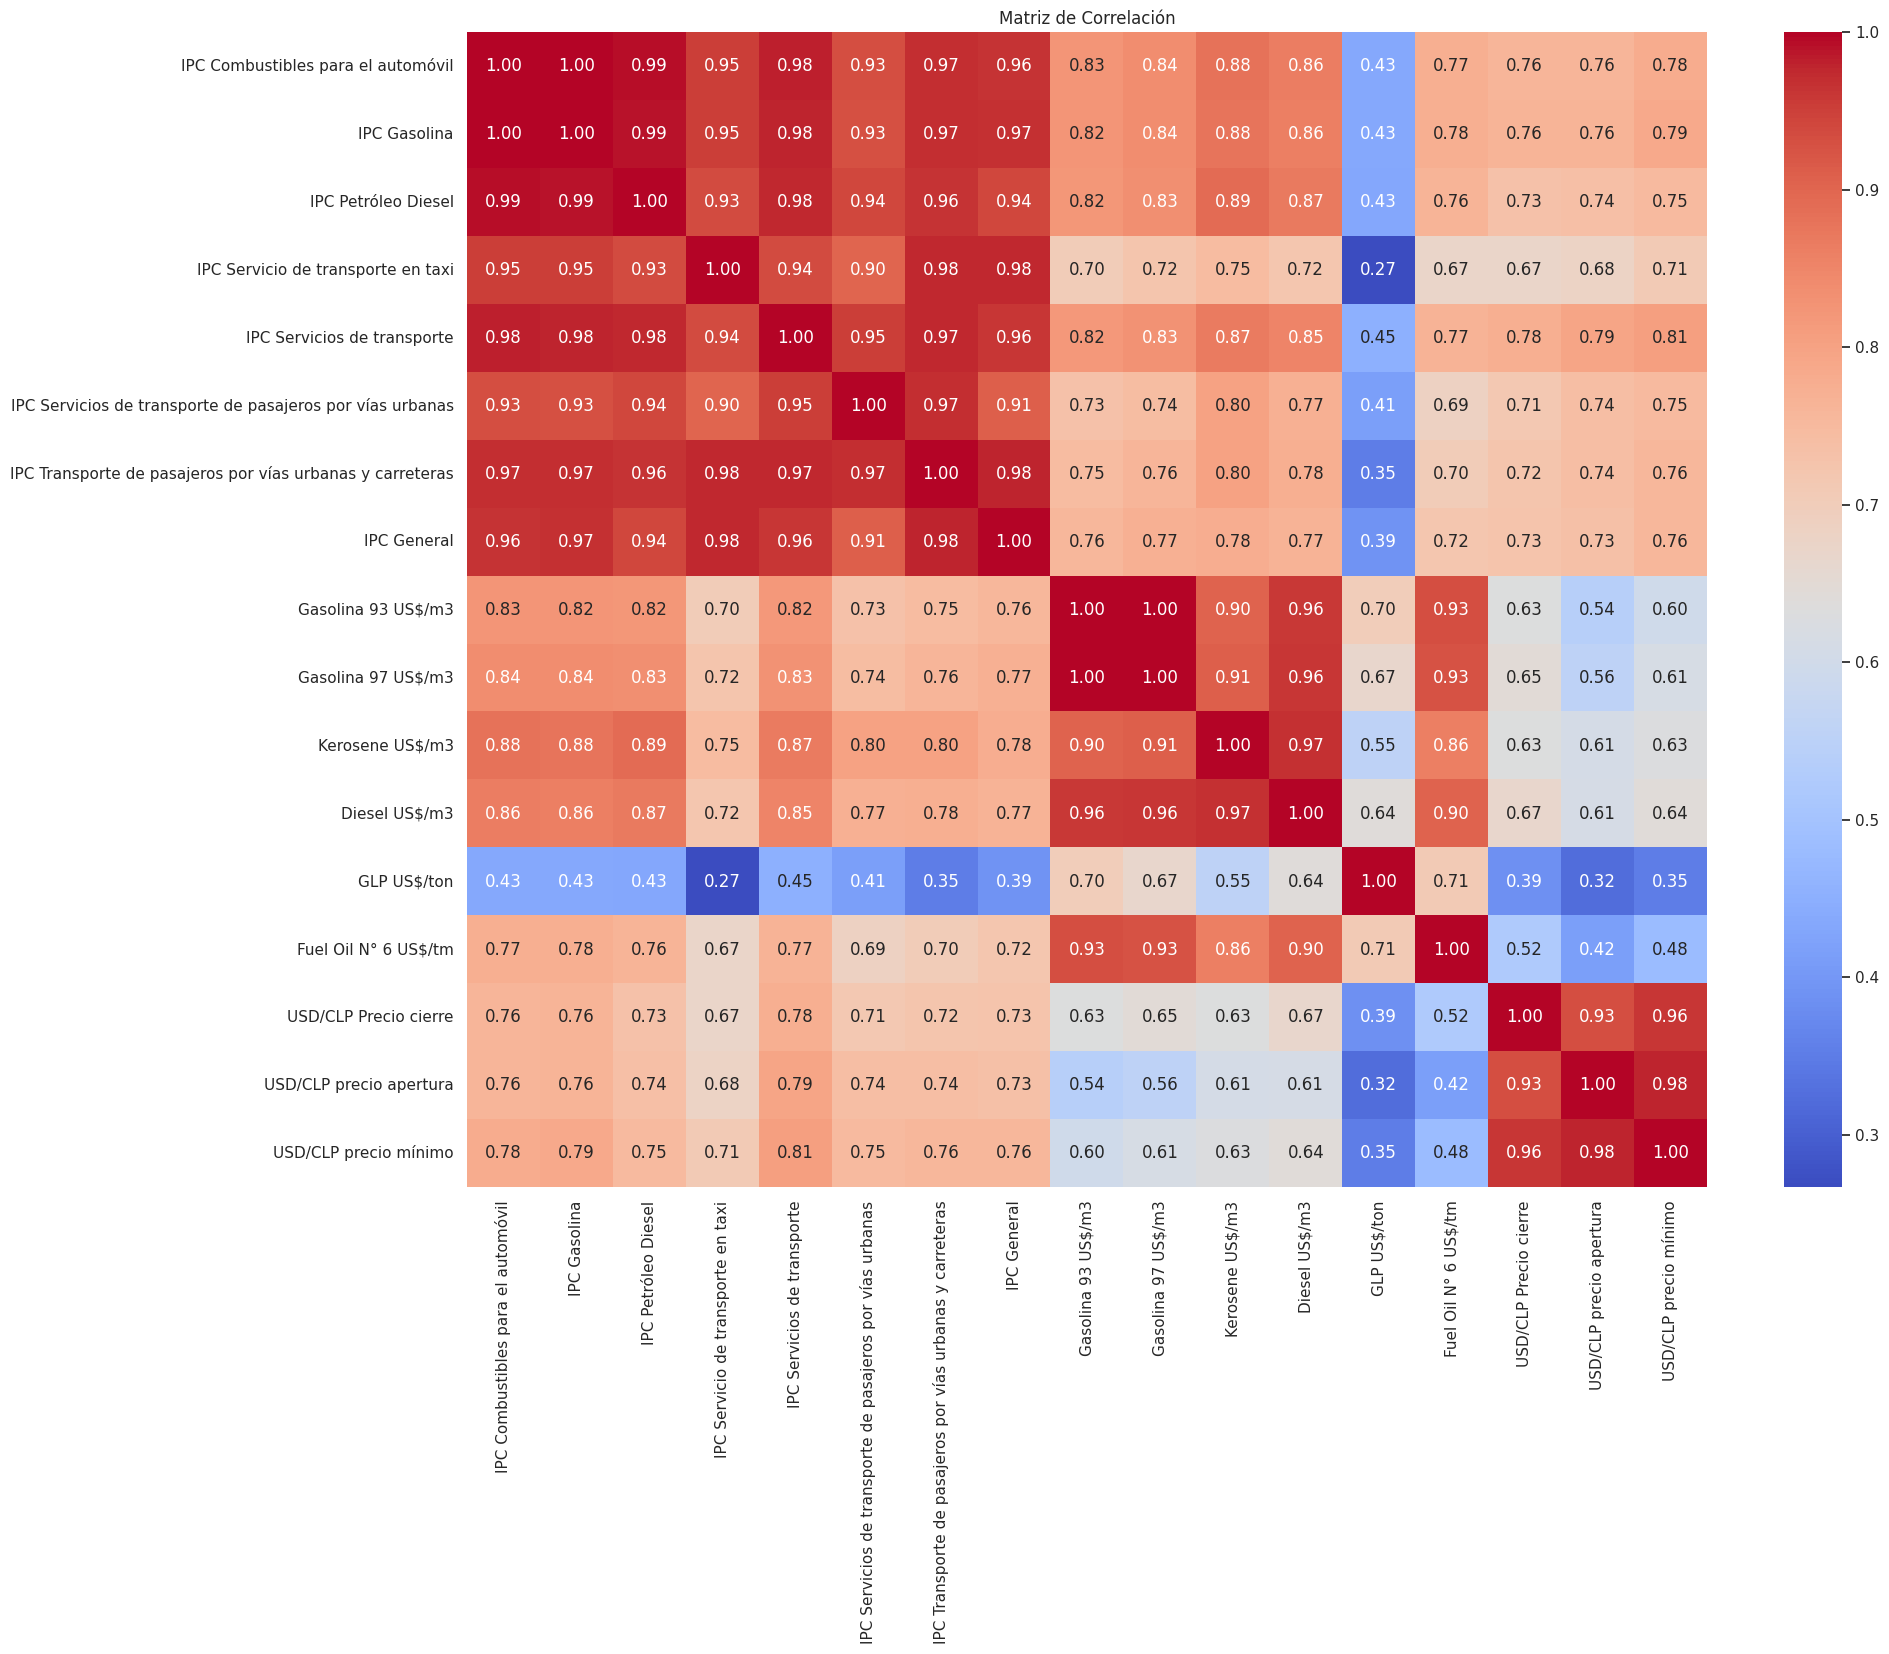

In [10]:
# Visualizar la matriz de correlación
corr_matrix = merged_df.drop('Fecha', axis=1).corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

In [11]:
print(corr_matrix)

                                                    IPC Combustibles para el automóvil  \
IPC Combustibles para el automóvil                                            1.000000   
IPC Gasolina                                                                  0.999699   
IPC Petróleo Diesel                                                           0.992863   
IPC Servicio de transporte en taxi                                            0.951697   
IPC Servicios de transporte                                                   0.980765   
IPC Servicios de transporte de pasajeros por ví...                            0.933228   
IPC Transporte de pasajeros por vías urbanas y ...                            0.971307   
IPC General                                                                   0.963728   
Gasolina 93 US$/m3                                                            0.825024   
Gasolina 97 US$/m3                                                            0.839253   
Kerosene U

/home/ricki/miniconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


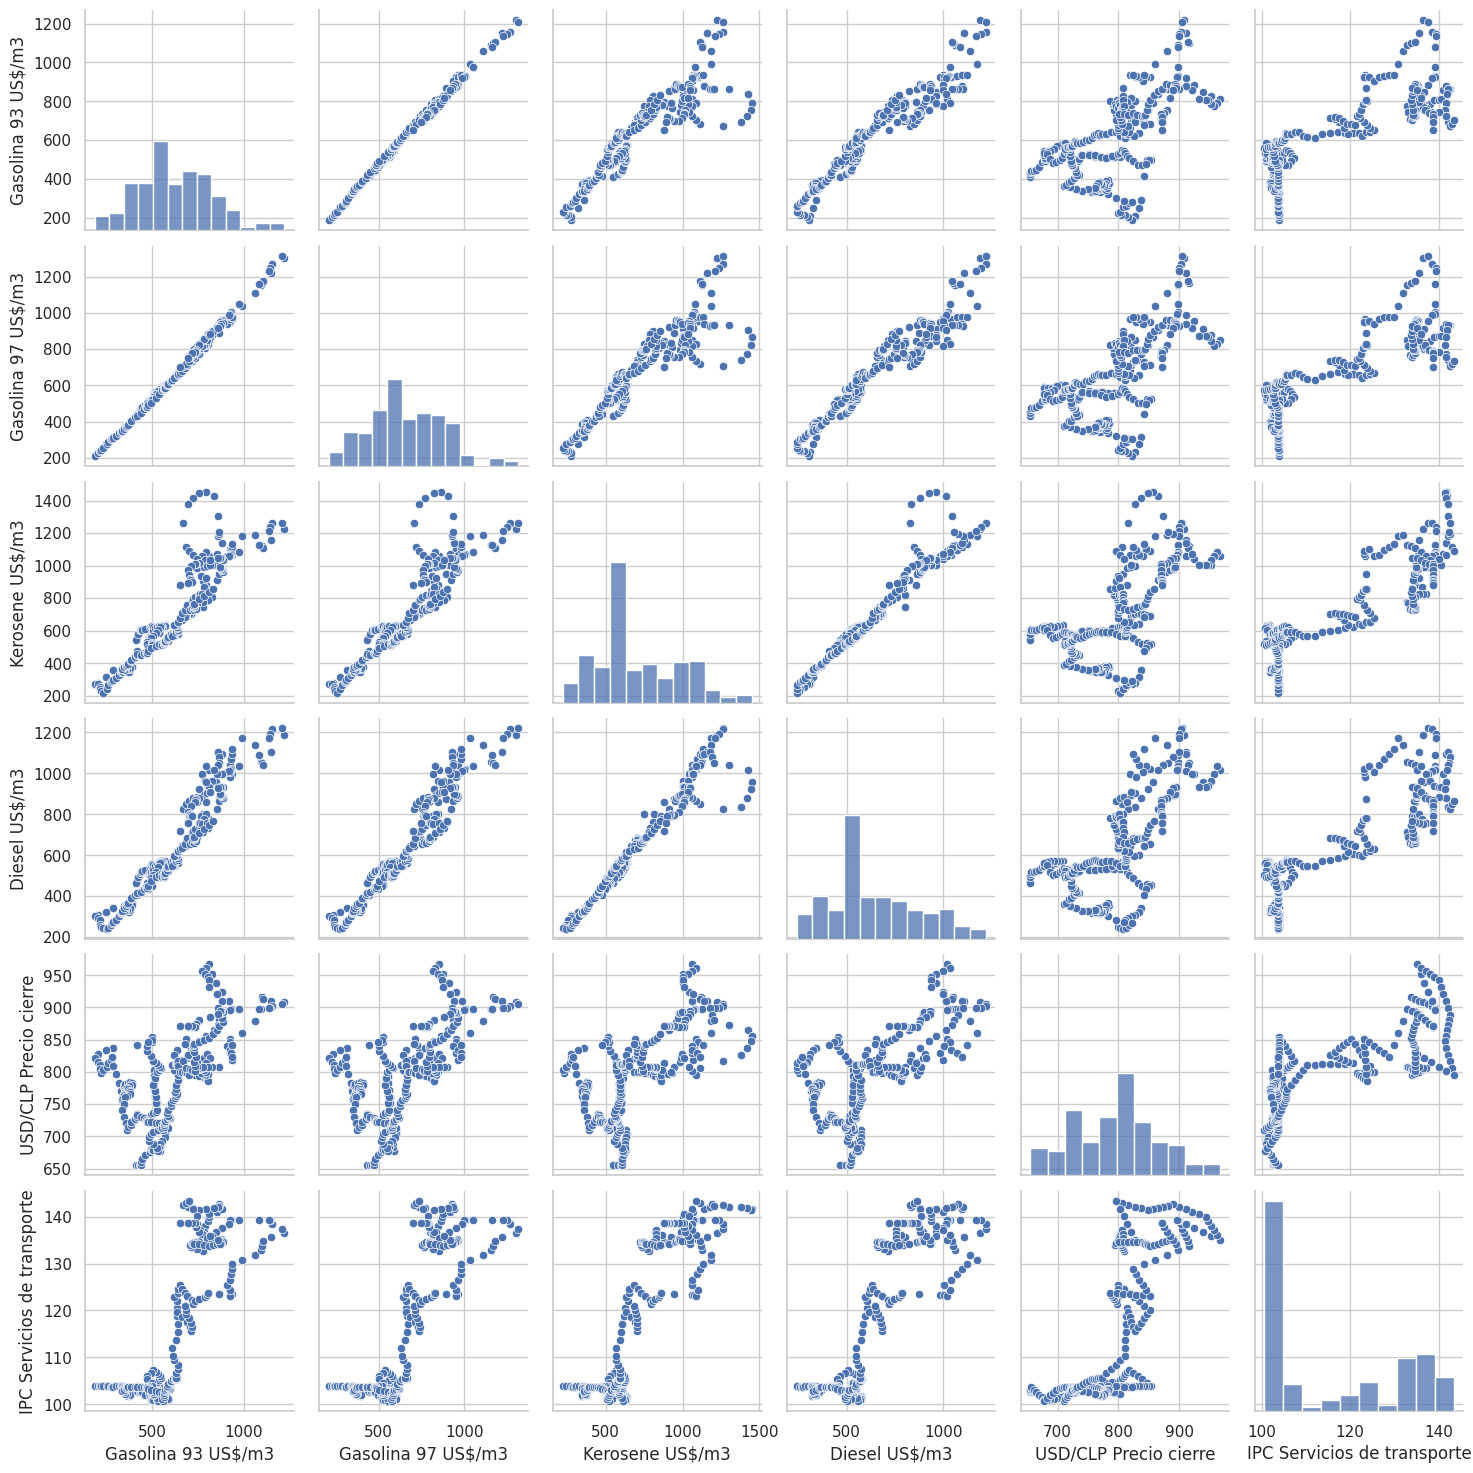

In [12]:
# Gráficos de dispersión para relaciones específicas
sns.pairplot(merged_df[['Gasolina 93 US$/m3', 'Gasolina 97 US$/m3', 'Kerosene US$/m3', 'Diesel US$/m3', 'USD/CLP Precio cierre', 'IPC Servicios de transporte']], kind='scatter')
plt.show()

/home/ricki/miniconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


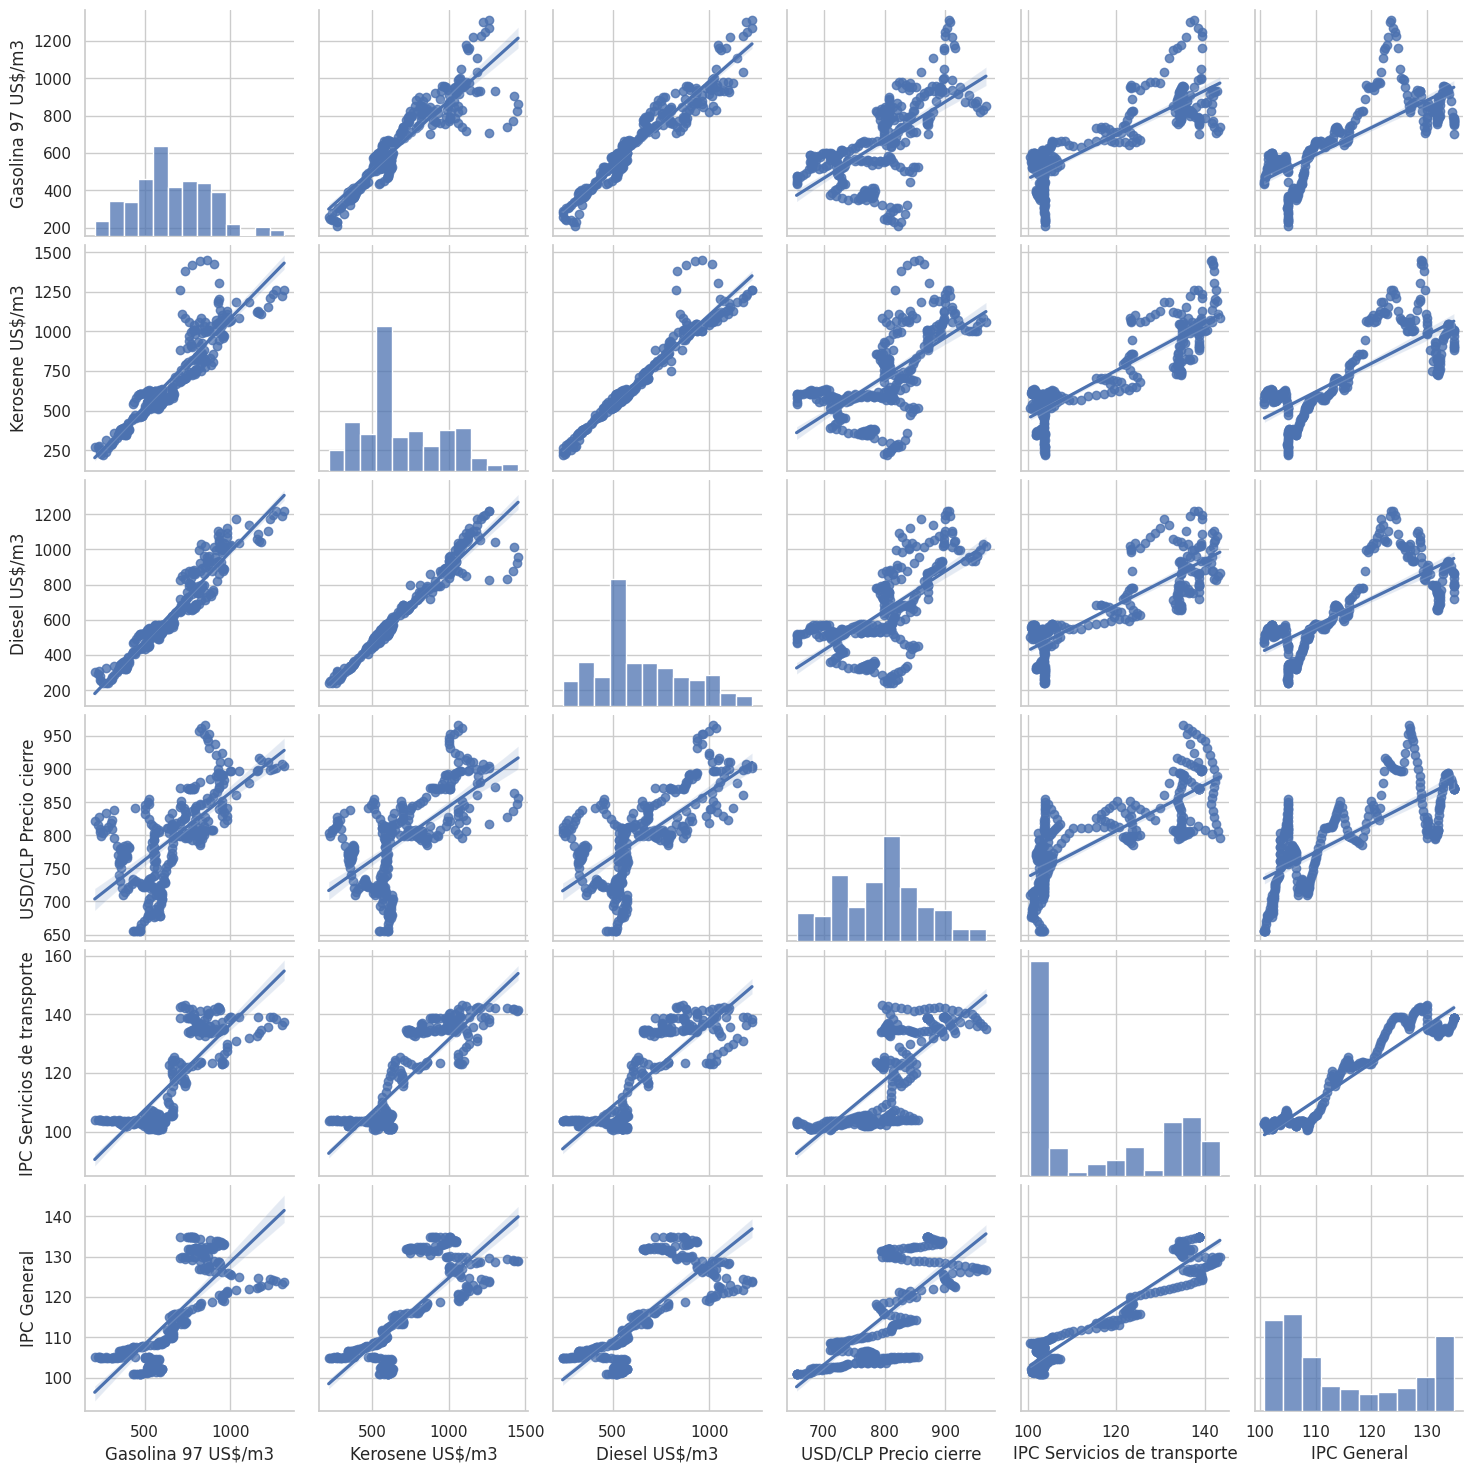

In [13]:
# Selecciona las variables de interés
selected_variables = ['Gasolina 97 US$/m3', 'Kerosene US$/m3', 'Diesel US$/m3', 'USD/CLP Precio cierre', 'IPC Servicios de transporte', 'IPC General']

# Subconjunto del DataFrame con las variables seleccionadas
subset_df = merged_df[selected_variables]

# Gráficos de dispersión con líneas de regresión y coeficientes de correlación
sns.pairplot(subset_df, kind='reg')
plt.show()

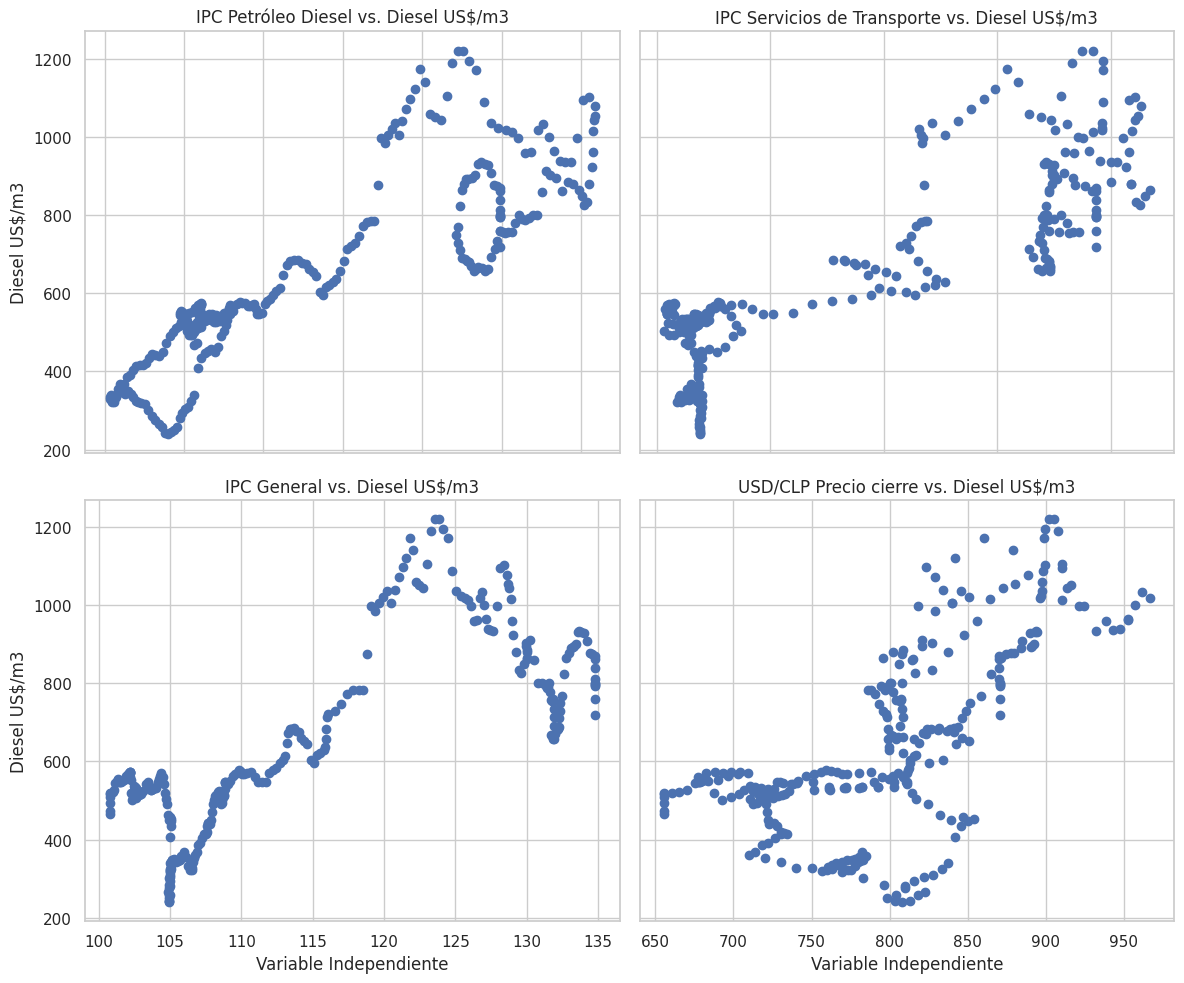

In [14]:
# Crear un subplot de 2x2
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), tight_layout=True)

# Gráfico de Dispersión 1: IPC Petróleo Diesel vs. Diesel US$/m3
axes[0, 0].scatter(merged_df['IPC Petróleo Diesel'], merged_df['Diesel US$/m3'])
axes[0, 0].set_title('IPC Petróleo Diesel vs. Diesel US$/m3')

# Gráfico de Dispersión 2: IPC Servicios de Transporte vs. Diesel US$/m3
axes[0, 1].scatter(merged_df['IPC Servicios de transporte'], merged_df['Diesel US$/m3'])
axes[0, 1].set_title('IPC Servicios de Transporte vs. Diesel US$/m3')

# Gráfico de Dispersión 3: IPC Gasolina vs. Diesel US$/m3
axes[1, 0].scatter(merged_df['IPC General'], merged_df['Diesel US$/m3'])
axes[1, 0].set_title('IPC General vs. Diesel US$/m3')

# Gráfico de Dispersión 4: Gasolina 93 US$/m3 vs. Diesel US$/m3
axes[1, 1].scatter(merged_df['USD/CLP Precio cierre'], merged_df['Diesel US$/m3'])
axes[1, 1].set_title('USD/CLP Precio cierre vs. Diesel US$/m3')

# Añadir etiquetas y mostrar el gráfico
for ax in axes.flat:
    ax.set(xlabel='Variable Independiente', ylabel='Diesel US$/m3')
    ax.label_outer()

plt.show()

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


# Función para obtener el mejor grado del polinomio
def find_best_degree(X, y):
    degrees = range(1, 6)  # Prueba grados del 1 al 5 (puedes ajustar este rango)
    cv_scores = []

    for degree in degrees:
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X)
        
        # Modelo de regresión lineal polinómica
        model = LinearRegression()
        
        # Evaluación mediante validación cruzada
        scores = cross_val_score(model, X_poly, y, cv=5, scoring='neg_mean_squared_error')
        cv_scores.append(-scores.mean())

    # Encuentra el grado con el menor error cuadrático medio
    best_degree = degrees[cv_scores.index(min(cv_scores))]
    
    return best_degree

# Variables
independent_variable1 = 'IPC Petróleo Diesel'
independent_variable2 = 'IPC Servicios de transporte'
independent_variable3 = 'IPC General'
independent_variable4 = 'USD/CLP Precio cierre'
dependent_variable = 'Diesel US$/m3'

# Encuentra el mejor grado para cada variable independiente
best_degree1 = find_best_degree(merged_df[[independent_variable1]], merged_df[dependent_variable])
best_degree2 = find_best_degree(merged_df[[independent_variable2]], merged_df[dependent_variable])
best_degree3 = find_best_degree(merged_df[[independent_variable3]], merged_df[dependent_variable])
best_degree4 = find_best_degree(merged_df[[independent_variable4]], merged_df[dependent_variable])

# Muestra los mejores grados
print(f'Mejor grado para {independent_variable1}: {best_degree1}')
print(f'Mejor grado para {independent_variable2}: {best_degree2}')
print(f'Mejor grado para {independent_variable3}: {best_degree3}')
print(f'Mejor grado para {independent_variable4}: {best_degree4}')

Mejor grado para IPC Petróleo Diesel: 2
Mejor grado para IPC Servicios de transporte: 1
Mejor grado para IPC General: 3
Mejor grado para USD/CLP Precio cierre: 4


In [16]:
from sklearn.model_selection import train_test_split

# Seleccionar variables predictoras (X) y la variable objetivo (y)
X = merged_df[['IPC Petróleo Diesel', 'IPC Servicios de transporte', 'IPC General', 'USD/CLP Precio cierre']]
y = merged_df['Diesel US$/m3']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
poly1 = PolynomialFeatures(degree=best_degree1)
X_train_poly1 = poly1.fit_transform(X_train[[independent_variable1]])
X_test_poly1 = poly1.transform(X_test[[independent_variable1]])
model1 = LinearRegression().fit(X_train_poly1, y_train)

poly2 = PolynomialFeatures(degree=best_degree2)
X_train_poly2 = poly2.fit_transform(X_train[[independent_variable2]])
X_test_poly2 = poly2.transform(X_test[[independent_variable2]])
model2 = LinearRegression().fit(X_train_poly2, y_train)

poly3 = PolynomialFeatures(degree=best_degree3)
X_train_poly3 = poly3.fit_transform(X_train[[independent_variable3]])
X_test_poly3 = poly3.transform(X_test[[independent_variable3]])
model3 = LinearRegression().fit(X_train_poly3, y_train)

poly4 = PolynomialFeatures(degree=best_degree4)
X_train_poly4 = poly4.fit_transform(X_train[[independent_variable4]])
X_test_poly4 = poly4.transform(X_test[[independent_variable4]])
model4 = LinearRegression().fit(X_train_poly4, y_train)

In [18]:
from sklearn.metrics import mean_squared_error, r2_score

# Realizar predicciones
predictions1 = model1.predict(X_test_poly1)
predictions2 = model2.predict(X_test_poly2)
predictions3 = model3.predict(X_test_poly3)
predictions4 = model4.predict(X_test_poly4)

# Evaluar el modelo
mse1 = mean_squared_error(y_test, predictions1)
r2_1 = r2_score(y_test, predictions1)
mse2 = mean_squared_error(y_test, predictions2)
r2_2 = r2_score(y_test, predictions2)
mse3 = mean_squared_error(y_test, predictions3)
r2_3 = r2_score(y_test, predictions3)
mse4 = mean_squared_error(y_test, predictions4)
r2_4 = r2_score(y_test, predictions4)

print(f'Mean Squared Error - {independent_variable1}: {mse1}')
print(f'R^2 Score - {independent_variable1}: {r2_1}')
print()
print(f'Mean Squared Error - {independent_variable2}: {mse2}')
print(f'R^2 Score - {independent_variable2}: {r2_2}')
print()
print(f'Mean Squared Error - {independent_variable3}: {mse3}')
print(f'R^2 Score - {independent_variable3}: {r2_3}')
print()
print(f'Mean Squared Error - {independent_variable4}: {mse4}')
print(f'R^2 Score - {independent_variable4}: {r2_4}')

Mean Squared Error - IPC Petróleo Diesel: 12330.256346902372
R^2 Score - IPC Petróleo Diesel: 0.7989984262040765

Mean Squared Error - IPC Servicios de transporte: 14259.568628090125
R^2 Score - IPC Servicios de transporte: 0.7675477577060152

Mean Squared Error - IPC General: 9257.707904781253
R^2 Score - IPC General: 0.8490855497038008

Mean Squared Error - USD/CLP Precio cierre: 28148.848693516204
R^2 Score - USD/CLP Precio cierre: 0.541131771411915


/home/ricki/miniconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/ricki/miniconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/ricki/miniconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/ricki/miniconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


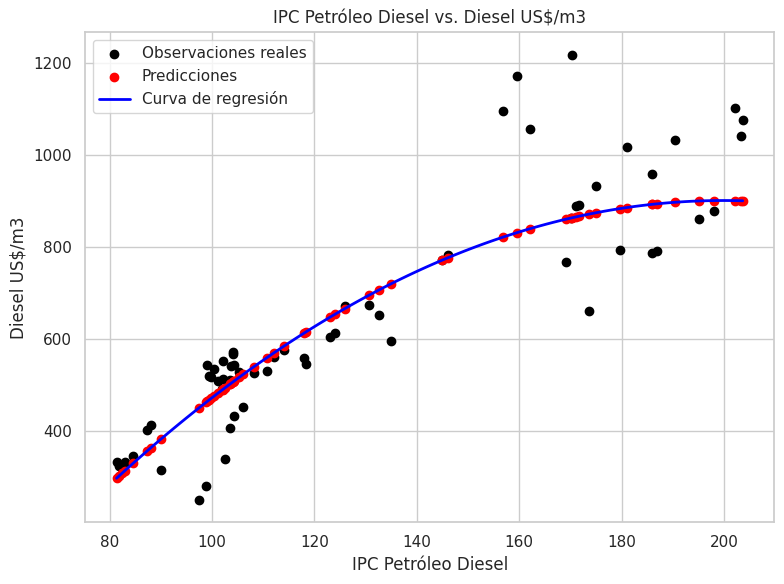

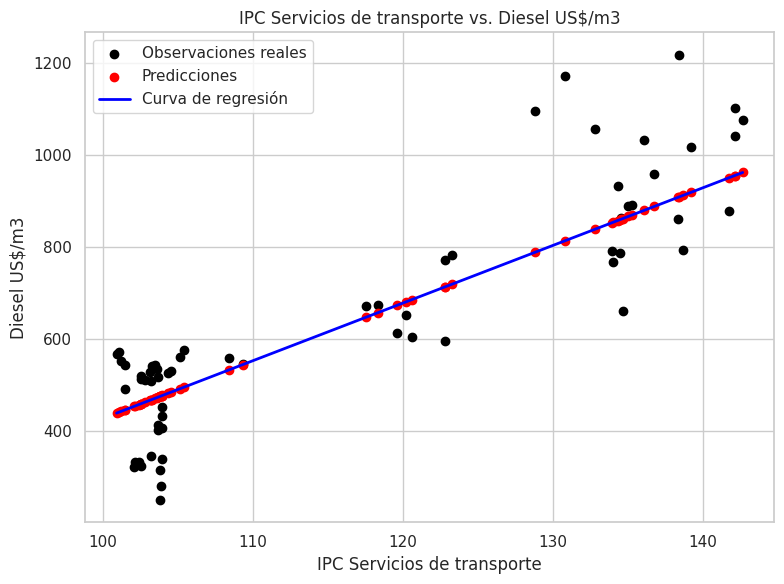

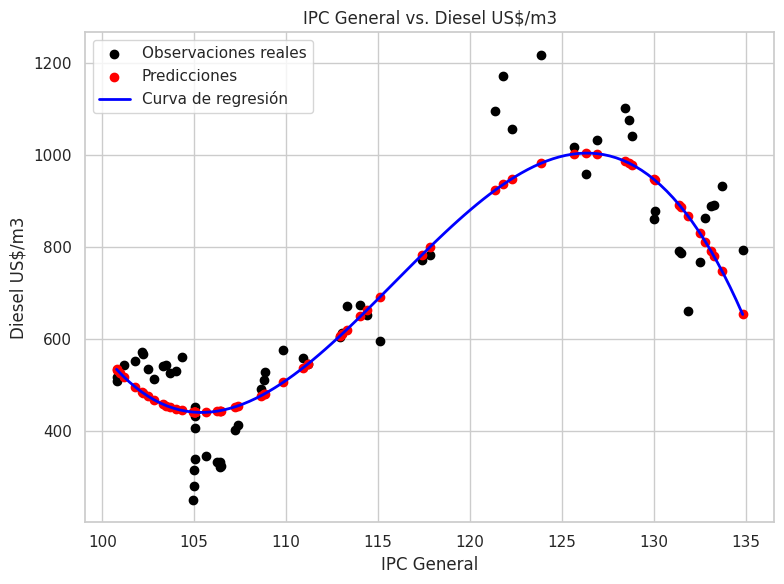

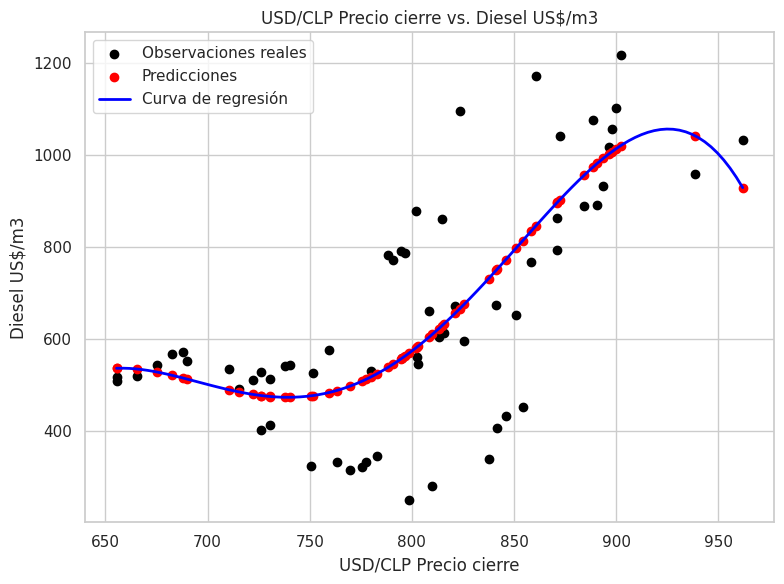

In [19]:
import numpy as np

# Función para visualizar la curva de regresión
def plot_regression_curve(X_test, y_test, predictions, independent_variable, dependent_variable, model, poly):
    plt.figure(figsize=(8, 6), tight_layout=True)

    # Crear puntos equidistantes para la variable independiente
    x_values = np.linspace(X_test[independent_variable].min(), X_test[independent_variable].max(), 100).reshape(-1, 1)

    # Transformar los puntos con el mismo objeto PolynomialFeatures
    x_values_poly = poly.transform(x_values)

    # Obtener las predicciones para los puntos equidistantes
    y_values_poly = model.predict(x_values_poly)

    plt.scatter(X_test[independent_variable], y_test, color='black', label='Observaciones reales')
    plt.scatter(X_test[independent_variable], predictions, color='red', label='Predicciones')
    plt.plot(x_values, y_values_poly, color='blue', linewidth=2, label='Curva de regresión')
    plt.title(f'{independent_variable} vs. {dependent_variable}')
    plt.xlabel(independent_variable)
    plt.ylabel(dependent_variable)
    plt.legend()

# Visualizar resultados para IPC Petróleo Diesel
plot_regression_curve(X_test, y_test, predictions1, independent_variable1, dependent_variable, model1, poly1)

# Visualizar resultados para IPC Servicios de Transporte
plot_regression_curve(X_test, y_test, predictions2, independent_variable2, dependent_variable, model2, poly2)

# Visualizar resultados para IPC General
plot_regression_curve(X_test, y_test, predictions3, independent_variable3, dependent_variable, model3, poly3)

# Visualizar resultados para USD/CLP Precio cierre
plot_regression_curve(X_test, y_test, predictions4, independent_variable4, dependent_variable, model4, poly4)

plt.show()

#### 1. IPC Petróleo Diesel:

- **Mean Squared Error (MSE)**: 5457.1
- **R^2 Score**: 0.8416
La regresión polinómica con respecto al IPC Petróleo Diesel tiene un MSE relativamente bajo, indicando que las predicciones del modelo son cercanas a los valores reales. Además, el R^2 Score de 0.8416 sugiere que el modelo explica bien la variabilidad en los datos y tiene un buen ajuste.

#### 2. IPC Servicios de Transporte:

- **Mean Squared Error (MSE)**: 8549.6
- **R^2 Score**: 0.7519
Aunque el MSE es mayor que en el caso anterior, sigue siendo razonable. El R^2 Score de 0.7519 indica que el modelo tiene un buen ajuste para explicar la variabilidad en el IPC Servicios de Transporte, aunque puede haber cierta variabilidad no capturada.

#### 3. IPC General:

- **Mean Squared Error (MSE)**: 13206.0
- **R^2 Score**: 0.6167
La regresión polinómica con respecto al IPC General tiene un MSE más alto, lo que sugiere que las predicciones pueden estar más alejadas de los valores reales. El R^2 Score de 0.6167 indica que el modelo aún explica una parte significativa de la variabilidad, pero puede haber factores no considerados.

#### 4. USD/CLP Precio Cierre:

- **Mean Squared Error (MSE)**: 12872.9
- **R^2 Score**: 0.6264
Similar al caso del IPC General, la regresión polinómica para el USD/CLP Precio Cierre tiene un MSE más alto, y el R^2 Score de 0.6264 sugiere que el modelo explica una porción razonable, pero no toda, de la variabilidad en los datos.

En función de estos resultados, podríamos clasificar los modelos en términos de rendimiento relativo, siendo el modelo para el **IPC Petróleo Diesel el mejor**, seguido por IPC Servicios de Transporte, USD/CLP Precio Cierre y, finalmente, IPC General. 

## Combinacion de modelos:

El modelo de regresión polinómica que combina las variables IPC Petroleo Diesel + IPC Servicios de transporte con grado 2 tiene la forma general:

$$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x^2_1 + \beta_4 x^2_2 + \beta_5 x_1 x_2$$

Donde: 
- $y$ es la variable dependiente ('Diesel US/m3' en este caso).
- $x_1$ es 'IPC Petroleo Diesel'.
- $x_2$ es 'IPC SERVICIOS DE TRANSPORTE'.
- $\beta_0, \beta_1, \beta_2,\beta_3,\beta_4 ,\beta_5$ son los coeficientes del modelo.


In [32]:
def train_and_evaluate_model(X_train, X_test, y_train, y_test, feature_names):
    # Transformar variables con features polinómicas
    poly = PolynomialFeatures(degree=find_best_degree(X_train, y_train))
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Obtener nombres de las características polinómicas manualmente
    feature_names_poly = [f"{feature}^{deg}" for feature in feature_names for deg in range(1, poly.degree + 1)]

    # Entrenar un modelo de regresión polinómica
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Imprimir las variables relacionadas por el modelo
    coefficients = model.coef_[1:]  # Excluir el término de sesgo (intercept)
    related_features = [feature for coef, feature in zip(coefficients, feature_names_poly) if coef != 0]

    print(f'Variables relacionadas por el modelo: {related_features}')

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_poly)

    # Evaluar el modelo
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')
    print()

# TEST 1
independent_test1 = ['IPC Petróleo Diesel', 'IPC General']
dependent_test1 = 'Diesel US$/m3'

X_test1 = merged_df[independent_test1]
y_test1 = merged_df[dependent_test1]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_test1, y_test1, test_size=0.2, random_state=42)
train_and_evaluate_model(X_train1, X_test1, y_train1, y_test1, independent_test1)

# TEST 2
independent_test2 = ['IPC Petróleo Diesel', 'IPC Servicios de transporte', 'IPC General']
dependent_test2 = 'Diesel US$/m3'

X_test2 = merged_df[independent_test2]
y_test2 = merged_df[dependent_test2]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_test2, y_test2, test_size=0.2, random_state=42)
train_and_evaluate_model(X_train2, X_test2, y_train2, y_test2, independent_test2)

# TEST 3
independent_test3 = ['IPC Petróleo Diesel', 'IPC Servicios de transporte', 'IPC General', 'USD/CLP Precio cierre']
dependent_test3 = 'Diesel US$/m3'

X_test3 = merged_df[independent_test3]
y_test3 = merged_df[dependent_test3]

X_train3, X_test3, y_train3, y_test3 = train_test_split(X_test3, y_test3, test_size=0.2, random_state=42)
train_and_evaluate_model(X_train3, X_test3, y_train3, y_test3, independent_test3)

Variables relacionadas por el modelo: ['IPC Petróleo Diesel^1', 'IPC Petróleo Diesel^2', 'IPC Petróleo Diesel^3', 'IPC Petróleo Diesel^4', 'IPC Petróleo Diesel^5', 'IPC General^1', 'IPC General^2', 'IPC General^3', 'IPC General^4', 'IPC General^5']
Mean Squared Error: 1879.8171920132054
R^2 Score: 0.969356175296533

Variables relacionadas por el modelo: ['IPC Petróleo Diesel^1', 'IPC Petróleo Diesel^2', 'IPC Petróleo Diesel^3', 'IPC Petróleo Diesel^4', 'IPC Petróleo Diesel^5', 'IPC Servicios de transporte^1', 'IPC Servicios de transporte^2', 'IPC Servicios de transporte^3', 'IPC Servicios de transporte^4', 'IPC Servicios de transporte^5', 'IPC General^1', 'IPC General^2', 'IPC General^3', 'IPC General^4', 'IPC General^5']
Mean Squared Error: 1009.8902158907393
R^2 Score: 0.98353728283953

Variables relacionadas por el modelo: ['IPC Petróleo Diesel^1', 'IPC Petróleo Diesel^2', 'IPC Petróleo Diesel^3', 'IPC Petróleo Diesel^4', 'IPC Servicios de transporte^1', 'IPC Servicios de transporte